# Exploration of confidence or certainty the predictions

In [1]:
run init.ipynb

Done.


#### Import

In [4]:
from sklearn.metrics import  (confusion_matrix, roc_curve, fbeta_score)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score, fbeta_score
import prg
from utils import compute_SD
from metrics import f1score, average_precision, bestf1score, calc_auprg, create_prg_curve

def compute_results(y_true, y_pred, threshold, name='?', title=""):


    # Compute imbalance_ratio of our sample
    pi = y_true.mean()
    correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))
    
    # Compute first AUROC
    auroc = roc_auc_score(y_true, y_pred)

    # Compute the AUC-PR
    auc_pr = average_precision_score(y_true, y_pred)

    # Compute the AUC-PR Corrected
    auc_pr_corrected = average_precision(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO)

    # Compute the AUC-PR Gain
    auc_pr_g = prg.calc_auprg(prg.create_prg_curve(y_true, y_pred))

    # Compute the AUC-PR Gain corrected
    auc_pr_g_corrected = calc_auprg(create_prg_curve(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO))
    
    # Compute f1 and f2 scores
    f1 = fbeta_score(y_true, y_pred > threshold, beta=1) 
    f2 = fbeta_score(y_true, y_pred >= threshold, beta=2) 

    # Compute the F1 score
    #f1, _ = bestf1score(y_true, y_pred, pi0=None)

    # Compute the corrected F1 score
    #f1_corrected, _ = bestf1score(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred >= threshold).ravel()

    # Compute corrected precision (ppv)
    ppv_corr = tp/(tp+correction_factor*fp)
    
    npv_corr = (correction_factor*tn)/(correction_factor*tn+fn)

    acc = (tp + tn) / (tp + tn + fp +  fn)
    mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    tpr =  tp / (tp+fn)
    tnr = tn / (tn+fp)
    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)
    fnr = fn / (tp+fn)
    
    # Compute corrected F1 and F2
    f1_c = 2*(ppv_corr*tpr)/(ppv_corr+tpr)
    
    beta = 2
    f2_c = (1+beta**2)*(ppv_corr*tpr)/(beta**2 * ppv_corr + tpr)

    performances_dict = {'name':name+'\n(N='+str(len(y_true))+')', 
                         'AUROC':round(auroc, 3),
                        'AUC-PR': round(auc_pr, 3),
                        'AUC-PR-Gain': round(auc_pr_g, 3),
                        'AUC-PR-Corrected': round(auc_pr_corrected, 3),
                        'AUC-PR-Gain-Corrected' :round(auc_pr_g_corrected, 3),
                        'F1 score (2 PPVxTPR/(PPV+TPR))': round(f1, 3),
                        'F1 score Corrected': round(f1_c, 3),
                        'F2': round(f2, 3),
                        'F2 Corrected': round(f2_c, 3),
                        'Accuracy' : round(acc, 3),
                        'Matthews correlation coefficient (MCC)': round(mcc, 3),
                        'Sensitivity, recall, hit rate, or true positive rate (TPR)': round(tpr, 3),
                        'Specificity, selectivity or true negative rate (TNR)': round(tnr, 3),
                        'Precision or positive predictive value (PPV)': round(ppv, 3),
                        'Corrected Precision or positive predictive value (PPV)': round(ppv_corr, 3),
                        'Corrected NPV': round(npv_corr, 3),
                        'Negative predictive value (NPV)': round(npv, 3),
                        'Miss rate or false negative rate (FNR)': round(fnr, 3),
                        'False discovery rate (FDR=1-PPV)': round(1-ppv, 3),
                        'False omission rate (FOR=1-NPV)': round(1-npv, 3),
                        'TP': tp,
                        'TN': tn,
                        'FP': fp,
                        'FN': fn
                        }
    
    performances_df = pd.DataFrame(performances_dict, index=[name+'\n(N='+str(len(y_true))+')'])

    performances_df['TN'] = tn
    performances_df['TP'] = tp
    performances_df['FP'] = fp
    performances_df['FN'] = fn

    performances_df['TN_normalized'] = 100*tn/len(y_true)
    performances_df['TP_normalized'] = 100*tp/len(y_true)
    performances_df['FP_normalized'] =  100*fp/len(y_true)
    performances_df['FN_normalized'] =  100*fn/len(y_true)    
    performances_df['N'] = len(y_true) 
    performances_df['y_true'] = [y_true]
    performances_df['y_pred'] = [y_pred]
    performances_df['Hanley_CI'] = performances_df['AUROC'] .apply(lambda x: compute_SD(x, np.sum(y_true==0), np.sum(y_true==1)))

    
    
    
    if False:
        display(performances_df)

        fig_mosaic = """
                        AB
                    """

        fig, axes = plt.subplot_mosaic(mosaic=fig_mosaic, figsize=(10,5))

        fig.suptitle(title, y=1.1, weight='bold', fontsize=12)

        cm = confusion_matrix(y_true, y_pred >= threshold)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', ax=axes['B']);disp.im_.colorbar.remove()    

        # Plot the roc curves

        fpr, tpr, _ = roc_curve(y_true, y_pred); roc_auc = auc(fpr, tpr)
        axes['A'].plot(fpr, tpr, '-', color='darkorange', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc,)
        axes['A'].plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
        axes['A'].set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.05]); axes['A'].grid()
        axes['A'].set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')

        plt.tight_layout()
        plt.show()
    return performances_df

def find_optimal_threshold_youden(y_true, y_pred):
    
    # Compute the performances using Younden Index
    
    # Compute all the possible threshold
    specificities_bar, sensitivities , thresholds = roc_curve(y_true, y_pred)

    specificities = 1 - specificities_bar

    younden_indexes = sensitivities + specificities - 1

    max_youden, index_threshold = np.max(younden_indexes),  np.argmax(younden_indexes)
    
    optimal_threshold = thresholds[index_threshold]
    
    
    return max_youden, index_threshold, optimal_threshold
if False:
    DEFAULT_PREDICTORS = [# GAZE RELATED
                     'mean_gaze_percent_right', #aggregated
                     'gaze_silhouette_score', #aggregated
                     'FP_gaze_speech_correlation',

                    # NAME CALL RELATED
                     'proportion_of_name_call_responses',
                     'average_response_to_name_delay',


                    # POSTURAL SWAY RELATED
                     'S_postural_sway',  #aggregated
                     'NS_postural_sway',  #aggregated
                     'S_postural_sway_derivative',
                     'NS_postural_sway_derivative',

                     'S_postural_sway_complexity', 
                     'NS_postural_sway_complexity',

                     # Blink rate
                     'S_blink_rate', 
                     'NS_blink_rate',

                     # Facing Forward
                     'S_facing_forward', 
                     'NS_facing_forward', 

                     # Facial complexity
                     'S_eyebrows_complexity', 
                     'NS_eyebrows_complexity', 
                     'S_mouth_complexity', 
                     'NS_mouth_complexity',

                    # TOUCH RELATED
                    'pop_rate', 'std_error', 'average_length', 'average_force_applied']
                    #'pop_rate', 'std_error']
    xgboost_hyperparameters = {'scale_pos_weight': True,
                                 'max_depth': 3,
                                 'learning_rate': 0.15,
                                 'gamma': 0.1,
                                 'n_estimators': 200,
                                 'min_child_weight': 1,
                                 'reg_lambda': 0.1}

    xgboost_hyperparameters ={'scale_pos_weight': True,
     'max_depth': 3,
     'learning_rate': 0.15,
     'gamma': 0.1,
     'n_estimators': 100,
     'min_child_weight': 1,
     'reg_lambda': 0.1}

In [ ]:
K = 500

random_states = np.random.randint(0, 1000, K)

for i, random_state in enumerate(random_states):

    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='imputation',
                   imputation_method='constant',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular_ddld', 
                   positive_class = [1],
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=False, #USE_MISSING_INDICATOR_PREDICTORS,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='multimodal_paper_ddld_final_cv10', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = i, 
                      verbosity=1, 
                      save_experiment=True)

    exp.fit_predict(num_cv=5, sample_weight=None, random_state=random_state)
    display(exp.performances_df)
    
    

Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 1!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,0,0.824,0.366,0.852,0.117,0.93,0.561,0.102,0.561,0.216,0.667,0.333,0.898,0.641,0.223,0.055,0.982,0.102,0.777,0.018,44,273,153,5


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 2!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,1,0.823,0.408,0.886,0.138,0.931,0.586,0.147,0.586,0.282,0.771,0.378,0.796,0.768,0.283,0.074,0.97,0.204,0.717,0.03,39,327,99,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 3!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,2,0.809,0.418,0.879,0.174,0.962,0.562,0.112,0.562,0.232,0.743,0.348,0.796,0.737,0.258,0.066,0.969,0.204,0.742,0.031,39,314,112,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 4!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,3,0.82,0.385,0.874,0.131,0.939,0.585,0.131,0.585,0.261,0.771,0.378,0.796,0.768,0.283,0.074,0.97,0.204,0.717,0.03,39,327,99,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 5!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,4,0.812,0.405,0.872,0.167,0.96,0.536,0.107,0.536,0.22,0.739,0.323,0.755,0.737,0.248,0.063,0.963,0.245,0.752,0.037,37,314,112,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 6!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,5,0.82,0.413,0.886,0.167,0.949,0.578,0.126,0.578,0.254,0.777,0.374,0.776,0.777,0.286,0.075,0.968,0.224,0.714,0.032,38,331,95,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 7!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,6,0.824,0.366,0.852,0.117,0.93,0.561,0.102,0.561,0.216,0.667,0.333,0.898,0.641,0.223,0.055,0.982,0.102,0.777,0.018,44,273,153,5


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 8!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,7,0.818,0.425,0.889,0.18,0.964,0.603,0.127,0.603,0.258,0.766,0.394,0.837,0.758,0.285,0.074,0.976,0.163,0.715,0.024,41,323,103,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 9!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,8,0.823,0.414,0.873,0.174,0.963,0.597,0.147,0.597,0.285,0.813,0.409,0.755,0.819,0.325,0.089,0.967,0.245,0.675,0.033,37,349,77,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 10!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,9,0.812,0.383,0.832,0.149,0.947,0.551,0.11,0.551,0.228,0.743,0.338,0.776,0.739,0.255,0.065,0.966,0.224,0.745,0.034,38,315,111,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 11!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,10,0.819,0.431,0.878,0.198,0.974,0.556,0.118,0.556,0.239,0.735,0.34,0.796,0.728,0.252,0.064,0.969,0.204,0.748,0.031,39,310,116,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 12!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,11,0.794,0.376,0.838,0.144,0.935,0.524,0.109,0.524,0.222,0.754,0.317,0.714,0.758,0.254,0.064,0.958,0.286,0.746,0.042,35,323,103,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 13!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,12,0.826,0.418,0.872,0.141,0.93,0.603,0.127,0.603,0.258,0.766,0.394,0.837,0.758,0.285,0.074,0.976,0.163,0.715,0.024,41,323,103,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 14!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,13,0.831,0.41,0.869,0.154,0.941,0.566,0.104,0.566,0.219,0.705,0.344,0.857,0.688,0.24,0.06,0.977,0.143,0.76,0.023,42,293,133,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 15!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,14,0.843,0.441,0.887,0.175,0.943,0.59,0.15,0.59,0.287,0.819,0.407,0.735,0.829,0.33,0.091,0.964,0.265,0.67,0.036,36,353,73,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 16!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,15,0.805,0.4,0.88,0.162,0.948,0.547,0.118,0.547,0.238,0.768,0.343,0.735,0.772,0.271,0.07,0.962,0.265,0.729,0.038,36,329,97,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 17!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,16,0.844,0.479,0.908,0.214,0.975,0.587,0.113,0.587,0.237,0.733,0.369,0.857,0.718,0.259,0.066,0.978,0.143,0.741,0.022,42,306,120,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 18!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,17,0.818,0.42,0.885,0.176,0.963,0.562,0.128,0.562,0.254,0.712,0.339,0.837,0.697,0.241,0.06,0.974,0.163,0.759,0.026,41,297,129,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 19!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,18,0.8,0.352,0.795,0.121,0.905,0.544,0.116,0.544,0.234,0.764,0.339,0.735,0.768,0.267,0.068,0.962,0.265,0.733,0.038,36,327,99,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 20!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,19,0.812,0.358,0.812,0.123,0.919,0.561,0.134,0.561,0.261,0.8,0.371,0.714,0.81,0.302,0.08,0.961,0.286,0.698,0.039,35,345,81,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 21!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,20,0.822,0.39,0.853,0.161,0.956,0.574,0.144,0.574,0.277,0.815,0.391,0.714,0.826,0.321,0.087,0.962,0.286,0.679,0.038,35,352,74,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 22!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,21,0.821,0.384,0.88,0.125,0.893,0.556,0.123,0.556,0.247,0.735,0.34,0.796,0.728,0.252,0.064,0.969,0.204,0.748,0.031,39,310,116,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 23!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,22,0.818,0.427,0.896,0.168,0.945,0.574,0.144,0.574,0.277,0.815,0.391,0.714,0.826,0.321,0.087,0.962,0.286,0.679,0.038,35,352,74,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 24!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,23,0.795,0.396,0.869,0.178,0.969,0.528,0.107,0.528,0.219,0.743,0.316,0.735,0.744,0.248,0.063,0.961,0.265,0.752,0.039,36,317,109,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 25!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,24,0.833,0.413,0.879,0.152,0.939,0.588,0.148,0.588,0.284,0.817,0.404,0.735,0.826,0.327,0.09,0.964,0.265,0.673,0.036,36,352,74,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 26!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,25,0.805,0.365,0.837,0.125,0.897,0.556,0.113,0.556,0.232,0.72,0.336,0.816,0.709,0.244,0.061,0.971,0.184,0.756,0.029,40,302,124,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 27!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,26,0.829,0.432,0.879,0.186,0.969,0.581,0.174,0.581,0.313,0.851,0.426,0.673,0.871,0.375,0.108,0.959,0.327,0.625,0.041,33,371,55,16


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 28!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,27,0.844,0.435,0.898,0.159,0.944,0.593,0.131,0.593,0.262,0.781,0.39,0.796,0.779,0.293,0.077,0.971,0.204,0.707,0.029,39,332,94,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 29!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,28,0.803,0.383,0.857,0.139,0.928,0.514,0.099,0.514,0.207,0.724,0.297,0.735,0.723,0.234,0.058,0.96,0.265,0.766,0.04,36,308,118,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 30!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,29,0.815,0.435,0.887,0.212,0.977,0.547,0.118,0.547,0.238,0.768,0.343,0.735,0.772,0.271,0.07,0.962,0.265,0.729,0.038,36,329,97,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 31!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,30,0.831,0.419,0.876,0.178,0.967,0.616,0.134,0.616,0.271,0.781,0.41,0.837,0.775,0.299,0.079,0.976,0.163,0.701,0.024,41,330,96,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 32!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,31,0.831,0.421,0.869,0.156,0.934,0.581,0.119,0.581,0.244,0.754,0.37,0.816,0.746,0.27,0.07,0.972,0.184,0.73,0.028,40,318,108,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 33!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,32,0.821,0.408,0.879,0.159,0.943,0.561,0.134,0.561,0.261,0.8,0.371,0.714,0.81,0.302,0.08,0.961,0.286,0.698,0.039,35,345,81,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 34!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,33,0.825,0.467,0.911,0.207,0.968,0.617,0.148,0.617,0.289,0.808,0.424,0.796,0.81,0.325,0.089,0.972,0.204,0.675,0.028,39,345,81,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 35!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,34,0.807,0.346,0.803,0.115,0.884,0.561,0.152,0.561,0.284,0.781,0.358,0.735,0.786,0.283,0.074,0.963,0.265,0.717,0.037,36,335,91,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 36!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,35,0.831,0.417,0.898,0.151,0.941,0.591,0.112,0.591,0.235,0.724,0.372,0.878,0.707,0.256,0.065,0.98,0.122,0.744,0.02,43,301,125,6


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 37!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,36,0.851,0.479,0.927,0.21,0.953,0.615,0.14,0.615,0.279,0.794,0.415,0.816,0.791,0.31,0.083,0.974,0.184,0.69,0.026,40,337,89,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 38!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,37,0.818,0.42,0.881,0.174,0.961,0.544,0.107,0.544,0.222,0.735,0.329,0.776,0.73,0.248,0.063,0.966,0.224,0.752,0.034,38,311,115,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 39!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,38,0.819,0.397,0.868,0.133,0.938,0.557,0.114,0.557,0.234,0.722,0.338,0.816,0.711,0.245,0.062,0.971,0.184,0.755,0.029,40,303,123,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 40!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,39,0.831,0.444,0.891,0.181,0.956,0.556,0.109,0.556,0.226,0.735,0.34,0.796,0.728,0.252,0.064,0.969,0.204,0.748,0.031,39,310,116,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 41!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,40,0.804,0.409,0.884,0.16,0.944,0.573,0.114,0.573,0.236,0.743,0.359,0.816,0.735,0.261,0.067,0.972,0.184,0.739,0.028,40,313,113,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 42!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,41,0.803,0.388,0.858,0.143,0.936,0.542,0.102,0.542,0.214,0.716,0.321,0.796,0.707,0.238,0.059,0.968,0.204,0.762,0.032,39,301,125,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 43!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,42,0.797,0.349,0.856,0.111,0.907,0.542,0.115,0.542,0.233,0.762,0.336,0.735,0.765,0.265,0.068,0.962,0.265,0.735,0.038,36,326,100,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 44!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,43,0.812,0.387,0.872,0.137,0.942,0.567,0.12,0.567,0.243,0.764,0.36,0.776,0.763,0.273,0.071,0.967,0.224,0.727,0.033,38,325,101,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 45!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,44,0.823,0.406,0.874,0.15,0.938,0.537,0.112,0.537,0.228,0.756,0.33,0.735,0.758,0.259,0.066,0.961,0.265,0.741,0.039,36,323,103,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 46!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,45,0.833,0.385,0.83,0.144,0.923,0.584,0.105,0.584,0.224,0.701,0.361,0.898,0.678,0.243,0.061,0.983,0.102,0.757,0.017,44,289,137,5


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 47!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,46,0.82,0.405,0.878,0.149,0.935,0.566,0.138,0.566,0.268,0.806,0.379,0.714,0.817,0.31,0.083,0.961,0.286,0.69,0.039,35,348,78,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 48!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,47,0.82,0.418,0.873,0.169,0.959,0.569,0.127,0.569,0.253,0.781,0.369,0.755,0.784,0.287,0.075,0.965,0.245,0.713,0.035,37,334,92,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 49!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,48,0.817,0.416,0.887,0.147,0.942,0.563,0.144,0.563,0.274,0.817,0.383,0.694,0.831,0.321,0.087,0.959,0.306,0.679,0.041,34,354,72,15


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 50!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,49,0.819,0.4,0.834,0.179,0.965,0.6,0.136,0.6,0.27,0.789,0.4,0.796,0.789,0.302,0.081,0.971,0.204,0.698,0.029,39,336,90,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 51!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,50,0.822,0.421,0.861,0.178,0.966,0.569,0.16,0.569,0.295,0.72,0.347,0.837,0.707,0.247,0.062,0.974,0.163,0.753,0.026,41,301,125,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 52!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,51,0.851,0.479,0.927,0.21,0.953,0.615,0.14,0.615,0.279,0.794,0.415,0.816,0.791,0.31,0.083,0.974,0.184,0.69,0.026,40,337,89,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 53!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,52,0.824,0.376,0.858,0.126,0.938,0.569,0.102,0.569,0.217,0.68,0.343,0.898,0.655,0.23,0.057,0.982,0.102,0.77,0.018,44,279,147,5


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 54!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,53,0.82,0.385,0.874,0.131,0.939,0.585,0.131,0.585,0.261,0.771,0.378,0.796,0.768,0.283,0.074,0.97,0.204,0.717,0.03,39,327,99,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 55!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,54,0.834,0.417,0.88,0.167,0.957,0.605,0.123,0.605,0.254,0.756,0.393,0.857,0.744,0.278,0.072,0.978,0.143,0.722,0.022,42,317,109,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 56!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,55,0.836,0.436,0.866,0.186,0.967,0.597,0.147,0.597,0.285,0.783,0.392,0.796,0.782,0.295,0.078,0.971,0.204,0.705,0.029,39,333,93,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 57!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,56,0.849,0.487,0.924,0.207,0.953,0.623,0.171,0.623,0.319,0.84,0.45,0.755,0.85,0.366,0.105,0.968,0.245,0.634,0.032,37,362,64,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 58!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,57,0.833,0.414,0.885,0.142,0.94,0.581,0.119,0.581,0.244,0.754,0.37,0.816,0.746,0.27,0.07,0.972,0.184,0.73,0.028,40,318,108,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 59!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,58,0.829,0.415,0.88,0.15,0.905,0.585,0.155,0.585,0.292,0.785,0.384,0.776,0.786,0.295,0.078,0.968,0.224,0.705,0.032,38,335,91,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 60!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,59,0.832,0.46,0.91,0.186,0.947,0.579,0.109,0.579,0.23,0.722,0.359,0.857,0.707,0.251,0.064,0.977,0.143,0.749,0.023,42,301,125,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 61!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,60,0.819,0.415,0.885,0.153,0.929,0.589,0.128,0.589,0.258,0.777,0.385,0.796,0.775,0.289,0.076,0.971,0.204,0.711,0.029,39,330,96,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 62!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,61,0.824,0.376,0.858,0.126,0.938,0.569,0.102,0.569,0.217,0.68,0.343,0.898,0.655,0.23,0.057,0.982,0.102,0.77,0.018,44,279,147,5


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 63!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,62,0.832,0.397,0.843,0.15,0.938,0.603,0.152,0.603,0.292,0.749,0.386,0.857,0.737,0.273,0.07,0.978,0.143,0.727,0.022,42,314,112,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 64!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,63,0.826,0.451,0.882,0.185,0.959,0.563,0.154,0.563,0.287,0.724,0.34,0.816,0.714,0.247,0.062,0.971,0.184,0.753,0.029,40,304,122,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 65!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,64,0.822,0.395,0.866,0.155,0.95,0.54,0.092,0.54,0.199,0.667,0.311,0.857,0.646,0.218,0.053,0.975,0.143,0.782,0.025,42,275,151,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 66!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,65,0.824,0.447,0.911,0.205,0.968,0.556,0.099,0.556,0.211,0.691,0.331,0.857,0.671,0.231,0.057,0.976,0.143,0.769,0.024,42,286,140,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 67!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,66,0.821,0.394,0.879,0.13,0.907,0.556,0.13,0.556,0.255,0.794,0.363,0.714,0.803,0.294,0.078,0.961,0.286,0.706,0.039,35,342,84,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 68!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,67,0.821,0.371,0.866,0.118,0.922,0.586,0.132,0.586,0.263,0.756,0.372,0.816,0.749,0.272,0.07,0.973,0.184,0.728,0.027,40,319,107,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 69!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,68,0.833,0.413,0.879,0.152,0.939,0.588,0.148,0.588,0.284,0.817,0.404,0.735,0.826,0.327,0.09,0.964,0.265,0.673,0.036,36,352,74,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 70!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,69,0.822,0.391,0.88,0.13,0.928,0.596,0.114,0.596,0.239,0.731,0.378,0.878,0.714,0.261,0.067,0.981,0.122,0.739,0.019,43,304,122,6


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 71!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,70,0.821,0.394,0.884,0.131,0.899,0.537,0.139,0.537,0.264,0.606,0.298,0.918,0.57,0.197,0.047,0.984,0.082,0.803,0.016,45,243,183,4


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 72!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,71,0.804,0.357,0.839,0.118,0.934,0.539,0.113,0.539,0.229,0.758,0.332,0.735,0.761,0.261,0.067,0.961,0.265,0.739,0.039,36,324,102,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 73!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,72,0.821,0.451,0.903,0.191,0.964,0.584,0.137,0.584,0.269,0.798,0.389,0.755,0.803,0.306,0.082,0.966,0.245,0.694,0.034,37,342,84,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 74!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,73,0.823,0.377,0.823,0.129,0.91,0.569,0.121,0.569,0.245,0.766,0.362,0.776,0.765,0.275,0.071,0.967,0.224,0.725,0.033,38,326,100,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 75!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,74,0.811,0.377,0.836,0.142,0.92,0.556,0.113,0.556,0.232,0.749,0.344,0.776,0.746,0.26,0.066,0.967,0.224,0.74,0.033,38,318,108,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 76!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,75,0.843,0.492,0.929,0.229,0.972,0.592,0.113,0.592,0.236,0.726,0.374,0.878,0.709,0.257,0.066,0.981,0.122,0.743,0.019,43,302,124,6


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 77!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,76,0.824,0.428,0.882,0.186,0.97,0.559,0.103,0.559,0.218,0.709,0.337,0.837,0.695,0.24,0.06,0.974,0.163,0.76,0.026,41,296,130,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 78!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,77,0.817,0.373,0.841,0.142,0.94,0.557,0.114,0.557,0.234,0.752,0.346,0.776,0.749,0.262,0.067,0.967,0.224,0.738,0.033,38,319,107,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 79!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,78,0.822,0.386,0.832,0.16,0.952,0.579,0.128,0.579,0.256,0.779,0.377,0.776,0.779,0.288,0.076,0.968,0.224,0.712,0.032,38,332,94,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 80!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,79,0.834,0.436,0.898,0.173,0.947,0.609,0.157,0.609,0.3,0.825,0.427,0.755,0.833,0.343,0.095,0.967,0.245,0.657,0.033,37,355,71,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 81!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,80,0.826,0.386,0.872,0.127,0.931,0.561,0.102,0.561,0.216,0.699,0.338,0.857,0.681,0.236,0.059,0.976,0.143,0.764,0.024,42,290,136,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 82!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,81,0.814,0.403,0.871,0.146,0.91,0.566,0.124,0.566,0.249,0.777,0.364,0.755,0.779,0.282,0.074,0.965,0.245,0.718,0.035,37,332,94,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 83!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,82,0.786,0.38,0.852,0.166,0.965,0.534,0.098,0.534,0.208,0.705,0.312,0.796,0.695,0.231,0.057,0.967,0.204,0.769,0.033,39,296,130,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 84!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,83,0.809,0.38,0.845,0.159,0.959,0.546,0.112,0.546,0.229,0.752,0.336,0.755,0.751,0.259,0.066,0.964,0.245,0.741,0.036,37,320,106,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 85!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,84,0.832,0.394,0.867,0.126,0.909,0.588,0.148,0.588,0.284,0.817,0.404,0.735,0.826,0.327,0.09,0.964,0.265,0.673,0.036,36,352,74,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 86!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,85,0.789,0.357,0.855,0.128,0.907,0.545,0.103,0.545,0.216,0.72,0.325,0.796,0.711,0.241,0.06,0.968,0.204,0.759,0.032,39,303,123,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 87!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,86,0.812,0.388,0.878,0.132,0.939,0.565,0.114,0.565,0.235,0.718,0.345,0.837,0.704,0.246,0.062,0.974,0.163,0.754,0.026,41,300,126,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 88!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,87,0.827,0.386,0.866,0.124,0.926,0.583,0.112,0.583,0.234,0.728,0.365,0.857,0.714,0.256,0.065,0.977,0.143,0.744,0.023,42,304,122,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 89!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,88,0.824,0.436,0.893,0.191,0.963,0.578,0.126,0.578,0.254,0.777,0.374,0.776,0.777,0.286,0.075,0.968,0.224,0.714,0.032,38,331,95,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 90!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,89,0.809,0.407,0.879,0.169,0.962,0.554,0.112,0.554,0.231,0.747,0.342,0.776,0.744,0.259,0.066,0.966,0.224,0.741,0.034,38,317,109,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 91!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,90,0.798,0.351,0.845,0.11,0.917,0.54,0.101,0.54,0.213,0.714,0.32,0.796,0.704,0.236,0.059,0.968,0.204,0.764,0.032,39,300,126,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 92!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,91,0.817,0.388,0.849,0.152,0.953,0.577,0.109,0.577,0.228,0.72,0.357,0.857,0.704,0.25,0.063,0.977,0.143,0.75,0.023,42,300,126,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 93!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,92,0.804,0.368,0.84,0.132,0.929,0.528,0.131,0.528,0.252,0.806,0.347,0.653,0.824,0.299,0.079,0.954,0.347,0.701,0.046,32,351,75,17


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 94!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,93,0.843,0.492,0.929,0.229,0.972,0.592,0.113,0.592,0.236,0.726,0.374,0.878,0.709,0.257,0.066,0.981,0.122,0.743,0.019,43,302,124,6


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 95!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,94,0.802,0.427,0.901,0.177,0.948,0.535,0.116,0.535,0.233,0.768,0.333,0.714,0.775,0.267,0.069,0.959,0.286,0.733,0.041,35,330,96,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 96!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,95,0.818,0.377,0.834,0.125,0.934,0.576,0.146,0.576,0.279,0.701,0.35,0.878,0.681,0.24,0.06,0.98,0.122,0.76,0.02,43,290,136,6


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 97!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,96,0.819,0.384,0.815,0.139,0.918,0.564,0.129,0.564,0.256,0.789,0.368,0.735,0.796,0.293,0.077,0.963,0.265,0.707,0.037,36,339,87,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 98!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,97,0.818,0.38,0.816,0.15,0.949,0.587,0.122,0.587,0.249,0.76,0.376,0.816,0.754,0.276,0.072,0.973,0.184,0.724,0.027,40,321,105,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 99!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,98,0.837,0.394,0.864,0.124,0.899,0.613,0.152,0.613,0.294,0.817,0.425,0.776,0.822,0.333,0.092,0.97,0.224,0.667,0.03,38,350,76,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 100!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,99,0.811,0.436,0.897,0.187,0.964,0.544,0.107,0.544,0.222,0.735,0.329,0.776,0.73,0.248,0.063,0.966,0.224,0.752,0.034,38,311,115,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 101!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,100,0.818,0.393,0.873,0.13,0.921,0.565,0.137,0.565,0.266,0.804,0.377,0.714,0.815,0.307,0.082,0.961,0.286,0.693,0.039,35,347,79,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 102!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,101,0.841,0.412,0.862,0.165,0.958,0.612,0.138,0.612,0.274,0.789,0.41,0.816,0.786,0.305,0.082,0.974,0.184,0.695,0.026,40,335,91,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 103!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,102,0.818,0.383,0.839,0.144,0.924,0.564,0.123,0.564,0.248,0.775,0.361,0.755,0.777,0.28,0.073,0.965,0.245,0.72,0.035,37,331,95,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 104!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,103,0.842,0.433,0.882,0.168,0.944,0.629,0.15,0.629,0.294,0.808,0.434,0.816,0.808,0.328,0.09,0.975,0.184,0.672,0.025,40,344,82,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 105!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,104,0.819,0.419,0.874,0.149,0.939,0.55,0.099,0.55,0.211,0.697,0.326,0.837,0.681,0.232,0.057,0.973,0.163,0.768,0.027,41,290,136,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 106!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,105,0.834,0.442,0.904,0.186,0.962,0.593,0.126,0.593,0.255,0.768,0.386,0.816,0.763,0.284,0.074,0.973,0.184,0.716,0.027,40,325,101,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 107!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,106,0.844,0.435,0.898,0.159,0.944,0.593,0.131,0.593,0.262,0.781,0.39,0.796,0.779,0.293,0.077,0.971,0.204,0.707,0.029,39,332,94,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 108!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,107,0.809,0.386,0.845,0.163,0.962,0.556,0.118,0.556,0.239,0.764,0.349,0.755,0.765,0.27,0.07,0.964,0.245,0.73,0.036,37,326,100,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 109!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,108,0.833,0.466,0.912,0.222,0.979,0.576,0.146,0.576,0.279,0.787,0.376,0.755,0.791,0.294,0.078,0.966,0.245,0.706,0.034,37,337,89,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 110!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,109,0.82,0.395,0.884,0.142,0.944,0.567,0.115,0.567,0.236,0.749,0.355,0.796,0.744,0.264,0.067,0.969,0.204,0.736,0.031,39,317,109,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 111!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,110,0.832,0.406,0.888,0.138,0.913,0.574,0.119,0.574,0.243,0.758,0.364,0.796,0.754,0.271,0.07,0.97,0.204,0.729,0.03,39,321,105,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 112!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,111,0.824,0.447,0.897,0.203,0.974,0.548,0.099,0.548,0.209,0.695,0.324,0.837,0.678,0.23,0.057,0.973,0.163,0.77,0.027,41,289,137,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 113!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,112,0.835,0.423,0.888,0.169,0.95,0.572,0.103,0.572,0.219,0.699,0.349,0.878,0.678,0.239,0.06,0.98,0.122,0.761,0.02,43,289,137,6


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 114!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,113,0.818,0.414,0.888,0.157,0.94,0.576,0.125,0.576,0.252,0.775,0.372,0.776,0.775,0.284,0.074,0.968,0.224,0.716,0.032,38,330,96,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 115!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,114,0.816,0.396,0.881,0.138,0.939,0.544,0.116,0.544,0.234,0.764,0.339,0.735,0.768,0.267,0.068,0.962,0.265,0.733,0.038,36,327,99,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 116!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,115,0.808,0.353,0.826,0.108,0.912,0.57,0.141,0.57,0.272,0.796,0.376,0.735,0.803,0.3,0.08,0.963,0.265,0.7,0.037,36,342,84,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 117!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,116,0.807,0.411,0.891,0.183,0.964,0.549,0.106,0.549,0.22,0.726,0.331,0.796,0.718,0.245,0.062,0.968,0.204,0.755,0.032,39,306,120,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 118!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,117,0.799,0.353,0.848,0.113,0.928,0.536,0.099,0.536,0.209,0.707,0.314,0.796,0.697,0.232,0.058,0.967,0.204,0.768,0.033,39,297,129,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 119!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,118,0.819,0.39,0.838,0.165,0.961,0.561,0.096,0.561,0.207,0.669,0.334,0.898,0.643,0.224,0.055,0.982,0.102,0.776,0.018,44,274,152,5


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 120!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,119,0.817,0.403,0.858,0.183,0.97,0.566,0.138,0.566,0.268,0.806,0.379,0.714,0.817,0.31,0.083,0.961,0.286,0.69,0.039,35,348,78,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 121!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,120,0.815,0.374,0.848,0.137,0.936,0.568,0.108,0.568,0.226,0.722,0.349,0.837,0.709,0.248,0.063,0.974,0.163,0.752,0.026,41,302,124,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 122!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,121,0.835,0.45,0.902,0.186,0.96,0.573,0.179,0.573,0.317,0.857,0.427,0.653,0.88,0.386,0.113,0.957,0.347,0.614,0.043,32,375,51,17


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 123!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,122,0.809,0.361,0.82,0.148,0.951,0.564,0.113,0.564,0.233,0.745,0.35,0.796,0.739,0.26,0.066,0.969,0.204,0.74,0.031,39,315,111,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 124!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,123,0.826,0.453,0.911,0.188,0.95,0.569,0.174,0.569,0.311,0.76,0.355,0.776,0.758,0.27,0.069,0.967,0.224,0.73,0.033,38,323,103,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 125!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,124,0.829,0.44,0.89,0.214,0.978,0.591,0.143,0.591,0.278,0.806,0.4,0.755,0.812,0.316,0.086,0.966,0.245,0.684,0.034,37,346,80,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 126!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,125,0.823,0.418,0.881,0.151,0.896,0.599,0.181,0.599,0.325,0.855,0.444,0.694,0.873,0.386,0.113,0.961,0.306,0.614,0.039,34,372,54,15


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 127!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,126,0.819,0.431,0.878,0.198,0.974,0.556,0.118,0.556,0.239,0.735,0.34,0.796,0.728,0.252,0.064,0.969,0.204,0.748,0.031,39,310,116,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 128!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,127,0.827,0.416,0.884,0.166,0.949,0.577,0.112,0.577,0.234,0.735,0.361,0.837,0.723,0.258,0.066,0.975,0.163,0.742,0.025,41,308,118,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 129!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,128,0.833,0.39,0.846,0.138,0.927,0.589,0.141,0.589,0.275,0.804,0.398,0.755,0.81,0.314,0.085,0.966,0.245,0.686,0.034,37,345,81,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 130!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,129,0.812,0.396,0.848,0.166,0.957,0.535,0.137,0.535,0.261,0.752,0.325,0.735,0.754,0.255,0.065,0.961,0.265,0.745,0.039,36,321,105,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 131!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,130,0.821,0.377,0.85,0.123,0.931,0.567,0.111,0.567,0.23,0.735,0.35,0.816,0.725,0.255,0.065,0.972,0.184,0.745,0.028,40,309,117,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 132!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,131,0.808,0.34,0.818,0.1,0.865,0.569,0.127,0.569,0.253,0.701,0.34,0.857,0.683,0.237,0.059,0.977,0.143,0.763,0.023,42,291,135,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 133!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,132,0.824,0.405,0.871,0.14,0.939,0.552,0.154,0.552,0.284,0.834,0.387,0.653,0.854,0.34,0.094,0.955,0.347,0.66,0.045,32,364,62,17


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 134!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,133,0.831,0.435,0.89,0.167,0.944,0.578,0.117,0.578,0.24,0.749,0.365,0.816,0.742,0.267,0.068,0.972,0.184,0.733,0.028,40,316,110,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 135!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,134,0.829,0.421,0.874,0.166,0.947,0.57,0.117,0.57,0.239,0.754,0.359,0.796,0.749,0.267,0.069,0.97,0.204,0.733,0.03,39,319,107,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 136!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,135,0.826,0.418,0.872,0.141,0.93,0.603,0.127,0.603,0.258,0.766,0.394,0.837,0.758,0.285,0.074,0.976,0.163,0.715,0.024,41,323,103,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 137!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,136,0.836,0.415,0.871,0.162,0.954,0.602,0.137,0.602,0.272,0.792,0.402,0.796,0.791,0.305,0.081,0.971,0.204,0.695,0.029,39,337,89,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 138!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,137,0.817,0.387,0.871,0.135,0.942,0.564,0.129,0.564,0.256,0.789,0.368,0.735,0.796,0.293,0.077,0.963,0.265,0.707,0.037,36,339,87,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 139!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,138,0.818,0.39,0.842,0.152,0.948,0.591,0.12,0.591,0.246,0.752,0.378,0.837,0.742,0.272,0.07,0.975,0.163,0.728,0.025,41,316,110,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 140!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,139,0.818,0.393,0.852,0.165,0.961,0.572,0.118,0.572,0.241,0.756,0.361,0.796,0.751,0.269,0.069,0.97,0.204,0.731,0.03,39,320,106,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 141!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,140,0.83,0.417,0.871,0.173,0.955,0.57,0.112,0.57,0.233,0.739,0.354,0.816,0.73,0.258,0.066,0.972,0.184,0.742,0.028,40,311,115,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 142!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,141,0.833,0.467,0.917,0.198,0.951,0.581,0.151,0.581,0.287,0.766,0.373,0.796,0.763,0.279,0.072,0.97,0.204,0.721,0.03,39,325,101,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 143!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,142,0.82,0.403,0.882,0.149,0.93,0.564,0.123,0.564,0.248,0.775,0.361,0.755,0.777,0.28,0.073,0.965,0.245,0.72,0.035,37,331,95,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 144!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,143,0.81,0.379,0.829,0.144,0.93,0.574,0.124,0.574,0.25,0.773,0.369,0.776,0.772,0.281,0.073,0.968,0.224,0.719,0.032,38,329,97,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 145!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,144,0.821,0.388,0.849,0.147,0.937,0.575,0.12,0.575,0.244,0.76,0.366,0.796,0.756,0.273,0.07,0.97,0.204,0.727,0.03,39,322,104,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 146!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,145,0.82,0.404,0.871,0.159,0.945,0.557,0.114,0.557,0.234,0.752,0.346,0.776,0.749,0.262,0.067,0.967,0.224,0.738,0.033,38,319,107,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 147!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,146,0.826,0.423,0.88,0.181,0.968,0.569,0.127,0.569,0.253,0.781,0.369,0.755,0.784,0.287,0.075,0.965,0.245,0.713,0.035,37,334,92,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 148!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,147,0.826,0.419,0.876,0.159,0.943,0.605,0.128,0.605,0.26,0.768,0.396,0.837,0.761,0.287,0.075,0.976,0.163,0.713,0.024,41,324,102,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 149!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,148,0.814,0.403,0.871,0.146,0.91,0.566,0.124,0.566,0.249,0.777,0.364,0.755,0.779,0.282,0.074,0.965,0.245,0.718,0.035,37,332,94,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 150!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,149,0.822,0.422,0.877,0.212,0.975,0.554,0.096,0.554,0.206,0.674,0.327,0.878,0.65,0.224,0.055,0.979,0.122,0.776,0.021,43,277,149,6


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 151!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,150,0.826,0.413,0.866,0.154,0.939,0.561,0.121,0.561,0.244,0.697,0.336,0.857,0.678,0.235,0.058,0.976,0.143,0.765,0.024,42,289,137,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 152!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,151,0.815,0.381,0.847,0.146,0.946,0.56,0.107,0.56,0.224,0.726,0.342,0.816,0.716,0.248,0.063,0.971,0.184,0.752,0.029,40,305,121,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 153!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,152,0.817,0.423,0.886,0.171,0.958,0.567,0.111,0.567,0.23,0.735,0.35,0.816,0.725,0.255,0.065,0.972,0.184,0.745,0.028,40,309,117,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 154!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,153,0.83,0.411,0.841,0.18,0.962,0.579,0.14,0.579,0.273,0.758,0.364,0.796,0.754,0.271,0.07,0.97,0.204,0.729,0.03,39,321,105,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 155!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,154,0.815,0.387,0.851,0.141,0.933,0.534,0.09,0.534,0.195,0.659,0.305,0.857,0.636,0.213,0.052,0.975,0.143,0.787,0.025,42,271,155,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 156!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,155,0.823,0.407,0.836,0.18,0.964,0.576,0.112,0.576,0.233,0.733,0.359,0.837,0.721,0.256,0.065,0.975,0.163,0.744,0.025,41,307,119,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 157!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,156,0.827,0.416,0.884,0.166,0.949,0.577,0.112,0.577,0.234,0.735,0.361,0.837,0.723,0.258,0.066,0.975,0.163,0.742,0.025,41,308,118,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 158!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,157,0.824,0.372,0.843,0.12,0.932,0.566,0.138,0.566,0.268,0.806,0.379,0.714,0.817,0.31,0.083,0.961,0.286,0.69,0.039,35,348,78,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 159!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,158,0.826,0.413,0.866,0.154,0.939,0.561,0.121,0.561,0.244,0.697,0.336,0.857,0.678,0.235,0.058,0.976,0.143,0.765,0.024,42,289,137,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 160!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,159,0.842,0.407,0.834,0.154,0.929,0.629,0.167,0.629,0.316,0.834,0.45,0.776,0.84,0.358,0.102,0.97,0.224,0.642,0.03,38,358,68,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 161!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,160,0.833,0.404,0.881,0.147,0.928,0.595,0.132,0.595,0.264,0.783,0.392,0.796,0.782,0.295,0.078,0.971,0.204,0.705,0.029,39,333,93,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 162!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,161,0.817,0.397,0.868,0.163,0.959,0.548,0.15,0.548,0.278,0.829,0.381,0.653,0.85,0.333,0.092,0.955,0.347,0.667,0.045,32,362,64,17


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 163!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,162,0.823,0.375,0.843,0.121,0.931,0.557,0.106,0.557,0.222,0.722,0.338,0.816,0.711,0.245,0.062,0.971,0.184,0.755,0.029,40,303,123,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 164!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,163,0.823,0.42,0.894,0.147,0.94,0.588,0.134,0.588,0.265,0.789,0.389,0.776,0.791,0.299,0.079,0.968,0.224,0.701,0.032,38,337,89,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 165!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,164,0.815,0.41,0.883,0.168,0.958,0.579,0.149,0.579,0.284,0.821,0.4,0.714,0.833,0.33,0.091,0.962,0.286,0.67,0.038,35,355,71,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 166!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,165,0.828,0.387,0.816,0.15,0.947,0.599,0.142,0.599,0.278,0.758,0.385,0.837,0.749,0.277,0.072,0.976,0.163,0.723,0.024,41,319,107,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 167!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,166,0.833,0.414,0.885,0.142,0.94,0.581,0.119,0.581,0.244,0.754,0.37,0.816,0.746,0.27,0.07,0.972,0.184,0.73,0.028,40,318,108,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 168!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,167,0.812,0.404,0.881,0.171,0.962,0.526,0.106,0.526,0.217,0.741,0.314,0.735,0.742,0.247,0.062,0.96,0.265,0.753,0.04,36,316,110,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 169!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,168,0.802,0.393,0.844,0.155,0.948,0.542,0.115,0.542,0.233,0.762,0.336,0.735,0.765,0.265,0.068,0.962,0.265,0.735,0.038,36,326,100,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 170!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,169,0.809,0.398,0.866,0.148,0.938,0.557,0.119,0.557,0.241,0.766,0.352,0.755,0.768,0.272,0.07,0.965,0.245,0.728,0.035,37,327,99,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 171!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,170,0.827,0.409,0.86,0.157,0.939,0.595,0.127,0.595,0.257,0.771,0.388,0.816,0.765,0.286,0.075,0.973,0.184,0.714,0.027,40,326,100,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 172!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,171,0.819,0.384,0.864,0.134,0.895,0.571,0.109,0.571,0.228,0.726,0.353,0.837,0.714,0.252,0.064,0.974,0.163,0.748,0.026,41,304,122,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 173!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,172,0.821,0.405,0.842,0.181,0.963,0.566,0.107,0.566,0.224,0.72,0.347,0.837,0.707,0.247,0.062,0.974,0.163,0.753,0.026,41,301,125,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 174!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,173,0.836,0.455,0.901,0.215,0.979,0.575,0.12,0.575,0.244,0.76,0.366,0.796,0.756,0.273,0.07,0.97,0.204,0.727,0.03,39,322,104,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 175!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,174,0.826,0.387,0.85,0.135,0.9,0.563,0.167,0.563,0.301,0.693,0.332,0.857,0.674,0.232,0.058,0.976,0.143,0.768,0.024,42,287,139,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 176!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,175,0.813,0.392,0.87,0.155,0.946,0.556,0.123,0.556,0.247,0.779,0.356,0.735,0.784,0.281,0.073,0.963,0.265,0.719,0.037,36,334,92,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 177!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,176,0.808,0.365,0.846,0.139,0.935,0.532,0.134,0.532,0.257,0.701,0.308,0.796,0.69,0.228,0.056,0.967,0.204,0.772,0.033,39,294,132,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 178!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,177,0.803,0.383,0.857,0.139,0.928,0.514,0.099,0.514,0.207,0.724,0.297,0.735,0.723,0.234,0.058,0.96,0.265,0.766,0.04,36,308,118,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 179!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,178,0.819,0.384,0.864,0.134,0.895,0.571,0.109,0.571,0.228,0.726,0.353,0.837,0.714,0.252,0.064,0.974,0.163,0.748,0.026,41,304,122,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 180!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,179,0.822,0.401,0.879,0.145,0.911,0.59,0.135,0.59,0.267,0.792,0.392,0.776,0.793,0.302,0.08,0.968,0.224,0.698,0.032,38,338,88,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 181!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,180,0.84,0.441,0.905,0.164,0.949,0.587,0.122,0.587,0.249,0.76,0.376,0.816,0.754,0.276,0.072,0.973,0.184,0.724,0.027,40,321,105,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 182!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,181,0.828,0.421,0.892,0.149,0.945,0.582,0.124,0.582,0.251,0.768,0.375,0.796,0.765,0.281,0.073,0.97,0.204,0.719,0.03,39,326,100,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 183!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,182,0.833,0.403,0.858,0.132,0.93,0.588,0.114,0.588,0.238,0.735,0.371,0.857,0.721,0.261,0.067,0.978,0.143,0.739,0.022,42,307,119,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 184!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,183,0.814,0.408,0.875,0.153,0.935,0.557,0.114,0.557,0.234,0.752,0.346,0.776,0.749,0.262,0.067,0.967,0.224,0.738,0.033,38,319,107,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 185!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,184,0.825,0.386,0.857,0.15,0.951,0.569,0.105,0.569,0.222,0.709,0.347,0.857,0.692,0.243,0.061,0.977,0.143,0.757,0.023,42,295,131,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 186!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,185,0.824,0.402,0.864,0.146,0.934,0.568,0.112,0.568,0.231,0.737,0.352,0.816,0.728,0.256,0.065,0.972,0.184,0.744,0.028,40,310,116,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 187!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,186,0.836,0.434,0.887,0.185,0.968,0.619,0.132,0.619,0.268,0.773,0.411,0.857,0.763,0.294,0.078,0.979,0.143,0.706,0.021,42,325,101,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 188!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,187,0.823,0.4,0.871,0.159,0.955,0.601,0.13,0.601,0.263,0.777,0.395,0.816,0.772,0.292,0.077,0.973,0.184,0.708,0.027,40,329,97,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 189!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,188,0.815,0.403,0.861,0.148,0.935,0.598,0.134,0.598,0.268,0.787,0.397,0.796,0.786,0.3,0.08,0.971,0.204,0.7,0.029,39,335,91,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 190!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,189,0.81,0.398,0.865,0.171,0.966,0.531,0.108,0.531,0.222,0.699,0.306,0.796,0.688,0.227,0.056,0.967,0.204,0.773,0.033,39,293,133,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 191!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,190,0.813,0.378,0.865,0.124,0.933,0.54,0.119,0.54,0.238,0.743,0.327,0.755,0.742,0.252,0.064,0.963,0.245,0.748,0.037,37,316,110,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 192!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,191,0.815,0.364,0.799,0.15,0.947,0.572,0.153,0.572,0.287,0.827,0.399,0.694,0.843,0.337,0.093,0.96,0.306,0.663,0.04,34,359,67,15


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 193!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,192,0.808,0.423,0.889,0.22,0.977,0.544,0.107,0.544,0.222,0.735,0.329,0.776,0.73,0.248,0.063,0.966,0.224,0.752,0.034,38,311,115,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 194!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,193,0.794,0.341,0.821,0.104,0.918,0.562,0.122,0.562,0.246,0.773,0.359,0.755,0.775,0.278,0.072,0.965,0.245,0.722,0.035,37,330,96,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 195!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,194,0.817,0.397,0.868,0.163,0.959,0.548,0.15,0.548,0.278,0.829,0.381,0.653,0.85,0.333,0.092,0.955,0.347,0.667,0.045,32,362,64,17


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 196!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,195,0.837,0.398,0.833,0.158,0.952,0.601,0.13,0.601,0.263,0.777,0.395,0.816,0.772,0.292,0.077,0.973,0.184,0.708,0.027,40,329,97,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 197!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,196,0.804,0.409,0.884,0.16,0.944,0.573,0.114,0.573,0.236,0.743,0.359,0.816,0.735,0.261,0.067,0.972,0.184,0.739,0.028,40,313,113,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 198!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,197,0.819,0.429,0.88,0.209,0.976,0.575,0.138,0.575,0.268,0.802,0.384,0.735,0.81,0.308,0.082,0.964,0.265,0.692,0.036,36,345,81,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 199!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,198,0.83,0.42,0.882,0.178,0.962,0.598,0.123,0.598,0.253,0.76,0.387,0.837,0.751,0.279,0.073,0.976,0.163,0.721,0.024,41,320,106,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 200!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,199,0.808,0.366,0.809,0.149,0.942,0.557,0.11,0.557,0.227,0.737,0.342,0.796,0.73,0.253,0.064,0.969,0.204,0.747,0.031,39,311,115,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 201!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,200,0.836,0.414,0.864,0.155,0.94,0.608,0.13,0.608,0.263,0.773,0.401,0.837,0.765,0.291,0.077,0.976,0.163,0.709,0.024,41,326,100,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 202!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,201,0.815,0.389,0.848,0.143,0.936,0.552,0.107,0.552,0.223,0.651,0.319,0.898,0.622,0.215,0.052,0.981,0.102,0.785,0.019,44,265,161,5


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 203!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,202,0.83,0.417,0.871,0.173,0.955,0.57,0.112,0.57,0.233,0.739,0.354,0.816,0.73,0.258,0.066,0.972,0.184,0.742,0.028,40,311,115,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 204!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,203,0.81,0.426,0.866,0.203,0.973,0.552,0.121,0.552,0.243,0.775,0.351,0.735,0.779,0.277,0.072,0.962,0.265,0.723,0.038,36,332,94,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 205!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,204,0.842,0.465,0.903,0.217,0.979,0.601,0.15,0.601,0.289,0.817,0.415,0.755,0.824,0.33,0.091,0.967,0.245,0.67,0.033,37,351,75,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 206!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,205,0.822,0.41,0.868,0.184,0.969,0.58,0.134,0.58,0.265,0.794,0.384,0.755,0.798,0.301,0.08,0.966,0.245,0.699,0.034,37,340,86,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 207!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,206,0.815,0.427,0.9,0.184,0.961,0.546,0.138,0.546,0.264,0.813,0.367,0.673,0.829,0.311,0.084,0.957,0.327,0.689,0.043,33,353,73,16


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 208!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,207,0.814,0.408,0.875,0.153,0.935,0.557,0.114,0.557,0.234,0.752,0.346,0.776,0.749,0.262,0.067,0.967,0.224,0.738,0.033,38,319,107,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 209!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,208,0.834,0.434,0.874,0.184,0.954,0.592,0.136,0.592,0.269,0.794,0.395,0.776,0.796,0.304,0.081,0.969,0.224,0.696,0.031,38,339,87,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 210!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,209,0.822,0.387,0.842,0.156,0.954,0.585,0.121,0.585,0.247,0.758,0.374,0.816,0.751,0.274,0.071,0.973,0.184,0.726,0.027,40,320,106,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 211!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,210,0.795,0.338,0.822,0.1,0.866,0.534,0.102,0.534,0.212,0.72,0.315,0.776,0.714,0.238,0.059,0.965,0.224,0.762,0.035,38,304,122,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 212!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,211,0.817,0.419,0.876,0.178,0.962,0.539,0.095,0.539,0.203,0.682,0.313,0.837,0.664,0.223,0.055,0.973,0.163,0.777,0.027,41,283,143,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 213!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,212,0.808,0.422,0.889,0.177,0.962,0.548,0.162,0.548,0.292,0.844,0.394,0.633,0.869,0.356,0.101,0.954,0.367,0.644,0.046,31,370,56,18


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 214!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,213,0.799,0.389,0.84,0.16,0.952,0.559,0.141,0.559,0.27,0.813,0.377,0.694,0.826,0.315,0.085,0.959,0.306,0.685,0.041,34,352,74,15


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 215!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,214,0.813,0.403,0.865,0.169,0.959,0.531,0.1,0.531,0.21,0.716,0.311,0.776,0.709,0.235,0.058,0.965,0.224,0.765,0.035,38,302,124,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 216!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,215,0.801,0.364,0.835,0.127,0.924,0.551,0.115,0.551,0.234,0.758,0.342,0.755,0.758,0.264,0.068,0.964,0.245,0.736,0.036,37,323,103,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 217!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,216,0.823,0.429,0.904,0.16,0.948,0.565,0.106,0.565,0.223,0.718,0.345,0.837,0.704,0.246,0.062,0.974,0.163,0.754,0.026,41,300,126,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 218!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,217,0.818,0.401,0.884,0.153,0.938,0.567,0.115,0.567,0.236,0.749,0.355,0.796,0.744,0.264,0.067,0.969,0.204,0.736,0.031,39,317,109,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 219!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,218,0.797,0.397,0.862,0.158,0.949,0.532,0.127,0.532,0.247,0.796,0.344,0.673,0.81,0.289,0.076,0.956,0.327,0.711,0.044,33,345,81,16


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 220!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,219,0.821,0.382,0.838,0.15,0.952,0.587,0.14,0.587,0.273,0.802,0.395,0.755,0.808,0.311,0.084,0.966,0.245,0.689,0.034,37,344,82,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 221!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,220,0.809,0.398,0.866,0.148,0.938,0.557,0.119,0.557,0.241,0.766,0.352,0.755,0.768,0.272,0.07,0.965,0.245,0.728,0.035,37,327,99,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 222!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,221,0.815,0.378,0.84,0.135,0.931,0.573,0.114,0.573,0.236,0.743,0.359,0.816,0.735,0.261,0.067,0.972,0.184,0.739,0.028,40,313,113,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 223!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,222,0.815,0.375,0.859,0.124,0.938,0.585,0.121,0.585,0.247,0.758,0.374,0.816,0.751,0.274,0.071,0.973,0.184,0.726,0.027,40,320,106,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 224!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,223,0.833,0.41,0.893,0.15,0.9,0.564,0.118,0.564,0.24,0.76,0.355,0.776,0.758,0.27,0.069,0.967,0.224,0.73,0.033,38,323,103,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 225!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,224,0.804,0.357,0.839,0.118,0.934,0.539,0.113,0.539,0.229,0.758,0.332,0.735,0.761,0.261,0.067,0.961,0.265,0.739,0.039,36,324,102,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 226!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,225,0.825,0.467,0.911,0.207,0.968,0.617,0.148,0.617,0.289,0.808,0.424,0.796,0.81,0.325,0.089,0.972,0.204,0.675,0.028,39,345,81,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 227!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,226,0.82,0.365,0.856,0.127,0.902,0.587,0.122,0.587,0.249,0.76,0.376,0.816,0.754,0.276,0.072,0.973,0.184,0.724,0.027,40,321,105,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 228!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,227,0.82,0.389,0.868,0.129,0.937,0.568,0.14,0.568,0.27,0.808,0.382,0.714,0.819,0.312,0.084,0.961,0.286,0.688,0.039,35,349,77,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 229!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,228,0.831,0.445,0.882,0.213,0.976,0.587,0.127,0.587,0.256,0.745,0.371,0.837,0.735,0.266,0.068,0.975,0.163,0.734,0.025,41,313,113,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 230!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,229,0.84,0.461,0.898,0.222,0.979,0.588,0.134,0.588,0.265,0.789,0.389,0.776,0.791,0.299,0.079,0.968,0.224,0.701,0.032,38,337,89,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 231!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,230,0.825,0.394,0.823,0.152,0.944,0.573,0.129,0.573,0.257,0.785,0.374,0.755,0.789,0.291,0.077,0.966,0.245,0.709,0.034,37,336,90,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 232!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,231,0.817,0.434,0.887,0.19,0.971,0.547,0.13,0.547,0.254,0.798,0.358,0.694,0.81,0.296,0.078,0.958,0.306,0.704,0.042,34,345,81,15


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 233!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,232,0.832,0.438,0.875,0.188,0.968,0.56,0.196,0.56,0.331,0.754,0.349,0.776,0.751,0.264,0.068,0.967,0.224,0.736,0.033,38,320,106,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 234!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,233,0.836,0.412,0.883,0.139,0.938,0.579,0.128,0.579,0.256,0.779,0.377,0.776,0.779,0.288,0.076,0.968,0.224,0.712,0.032,38,332,94,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 235!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,234,0.819,0.4,0.834,0.179,0.965,0.6,0.136,0.6,0.27,0.789,0.4,0.796,0.789,0.302,0.081,0.971,0.204,0.698,0.029,39,336,90,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 236!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,235,0.831,0.435,0.89,0.167,0.944,0.578,0.117,0.578,0.24,0.749,0.365,0.816,0.742,0.267,0.068,0.972,0.184,0.733,0.028,40,316,110,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 237!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,236,0.824,0.422,0.891,0.166,0.946,0.592,0.152,0.592,0.289,0.821,0.411,0.735,0.831,0.333,0.092,0.965,0.265,0.667,0.035,36,354,72,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 238!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,237,0.821,0.393,0.852,0.153,0.952,0.576,0.156,0.576,0.292,0.832,0.405,0.694,0.847,0.343,0.096,0.96,0.306,0.657,0.04,34,361,65,15


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 239!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,238,0.826,0.397,0.847,0.152,0.94,0.577,0.121,0.577,0.246,0.762,0.368,0.796,0.758,0.275,0.071,0.97,0.204,0.725,0.03,39,323,103,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 240!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,239,0.805,0.36,0.822,0.135,0.927,0.557,0.119,0.557,0.241,0.766,0.352,0.755,0.768,0.272,0.07,0.965,0.245,0.728,0.035,37,327,99,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 241!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,240,0.803,0.439,0.894,0.209,0.977,0.544,0.116,0.544,0.234,0.764,0.339,0.735,0.768,0.267,0.068,0.962,0.265,0.733,0.038,36,327,99,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 242!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,241,0.81,0.417,0.886,0.162,0.943,0.543,0.103,0.543,0.215,0.718,0.323,0.796,0.709,0.239,0.06,0.968,0.204,0.761,0.032,39,302,124,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 243!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,242,0.813,0.403,0.865,0.169,0.959,0.531,0.1,0.531,0.21,0.716,0.311,0.776,0.709,0.235,0.058,0.965,0.224,0.765,0.035,38,302,124,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 244!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,243,0.822,0.425,0.894,0.17,0.946,0.575,0.13,0.575,0.259,0.787,0.376,0.755,0.791,0.294,0.078,0.966,0.245,0.706,0.034,37,337,89,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 245!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,244,0.818,0.383,0.855,0.127,0.937,0.585,0.131,0.585,0.261,0.785,0.384,0.776,0.786,0.295,0.078,0.968,0.224,0.705,0.032,38,335,91,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 246!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,245,0.816,0.401,0.861,0.148,0.934,0.559,0.141,0.559,0.27,0.813,0.377,0.694,0.826,0.315,0.085,0.959,0.306,0.685,0.041,34,352,74,15


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 247!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,246,0.815,0.375,0.859,0.124,0.938,0.585,0.121,0.585,0.247,0.758,0.374,0.816,0.751,0.274,0.071,0.973,0.184,0.726,0.027,40,320,106,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 248!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,247,0.836,0.432,0.862,0.182,0.961,0.574,0.154,0.574,0.289,0.829,0.402,0.694,0.845,0.34,0.094,0.96,0.306,0.66,0.04,34,360,66,15


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 249!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,248,0.831,0.417,0.898,0.151,0.941,0.591,0.112,0.591,0.235,0.724,0.372,0.878,0.707,0.256,0.065,0.98,0.122,0.744,0.02,43,301,125,6


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 250!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,249,0.836,0.447,0.891,0.19,0.964,0.596,0.139,0.596,0.274,0.766,0.383,0.816,0.761,0.282,0.073,0.973,0.184,0.718,0.027,40,324,102,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 251!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,250,0.83,0.413,0.873,0.172,0.955,0.587,0.118,0.587,0.243,0.747,0.374,0.837,0.737,0.268,0.069,0.975,0.163,0.732,0.025,41,314,112,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 252!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,251,0.814,0.429,0.884,0.174,0.943,0.563,0.105,0.563,0.222,0.716,0.343,0.837,0.702,0.244,0.061,0.974,0.163,0.756,0.026,41,299,127,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 253!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,252,0.824,0.383,0.861,0.122,0.905,0.572,0.153,0.572,0.287,0.796,0.376,0.735,0.803,0.3,0.08,0.963,0.265,0.7,0.037,36,342,84,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 254!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,253,0.806,0.379,0.84,0.134,0.914,0.537,0.094,0.537,0.201,0.678,0.309,0.837,0.66,0.22,0.054,0.972,0.163,0.78,0.028,41,281,145,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 255!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,254,0.815,0.381,0.842,0.16,0.957,0.567,0.12,0.567,0.243,0.764,0.36,0.776,0.763,0.273,0.071,0.967,0.224,0.727,0.033,38,325,101,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 256!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,255,0.816,0.363,0.794,0.126,0.912,0.56,0.116,0.56,0.237,0.756,0.351,0.776,0.754,0.266,0.068,0.967,0.224,0.734,0.033,38,321,105,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 257!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,256,0.824,0.389,0.833,0.148,0.943,0.579,0.149,0.579,0.284,0.821,0.4,0.714,0.833,0.33,0.091,0.962,0.286,0.67,0.038,35,355,71,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 258!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,257,0.811,0.392,0.864,0.144,0.936,0.539,0.095,0.539,0.203,0.682,0.313,0.837,0.664,0.223,0.055,0.973,0.163,0.777,0.027,41,283,143,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 259!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,258,0.819,0.405,0.868,0.184,0.97,0.568,0.112,0.568,0.231,0.737,0.352,0.816,0.728,0.256,0.065,0.972,0.184,0.744,0.028,40,310,116,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 260!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,259,0.805,0.396,0.857,0.164,0.955,0.574,0.144,0.574,0.277,0.815,0.391,0.714,0.826,0.321,0.087,0.962,0.286,0.679,0.038,35,352,74,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 261!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,260,0.833,0.368,0.843,0.111,0.895,0.587,0.118,0.587,0.243,0.747,0.374,0.837,0.737,0.268,0.069,0.975,0.163,0.732,0.025,41,314,112,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 262!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,261,0.822,0.427,0.885,0.166,0.945,0.548,0.15,0.548,0.278,0.829,0.381,0.653,0.85,0.333,0.092,0.955,0.347,0.667,0.045,32,362,64,17


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 263!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,262,0.824,0.376,0.858,0.126,0.938,0.569,0.102,0.569,0.217,0.68,0.343,0.898,0.655,0.23,0.057,0.982,0.102,0.77,0.018,44,279,147,5


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 264!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,263,0.817,0.366,0.832,0.136,0.895,0.559,0.12,0.559,0.242,0.754,0.349,0.776,0.751,0.264,0.068,0.967,0.224,0.736,0.033,38,320,106,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 265!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,264,0.829,0.421,0.874,0.166,0.947,0.57,0.117,0.57,0.239,0.754,0.359,0.796,0.749,0.267,0.069,0.97,0.204,0.733,0.03,39,319,107,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 266!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,265,0.824,0.412,0.866,0.185,0.97,0.586,0.132,0.586,0.263,0.787,0.387,0.776,0.789,0.297,0.079,0.968,0.224,0.703,0.032,38,336,90,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 267!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,266,0.813,0.399,0.877,0.147,0.943,0.543,0.103,0.543,0.215,0.718,0.323,0.796,0.709,0.239,0.06,0.968,0.204,0.761,0.032,39,302,124,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 268!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,267,0.822,0.409,0.878,0.142,0.942,0.566,0.185,0.566,0.322,0.669,0.324,0.878,0.646,0.222,0.054,0.979,0.122,0.778,0.021,43,275,151,6


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 269!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,268,0.813,0.386,0.861,0.133,0.94,0.538,0.118,0.538,0.236,0.661,0.306,0.857,0.638,0.214,0.052,0.975,0.143,0.786,0.025,42,272,154,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 270!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,269,0.829,0.432,0.905,0.156,0.935,0.597,0.147,0.597,0.285,0.781,0.39,0.796,0.779,0.293,0.077,0.971,0.204,0.707,0.029,39,332,94,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 271!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,270,0.824,0.399,0.855,0.161,0.957,0.569,0.121,0.569,0.245,0.766,0.362,0.776,0.765,0.275,0.071,0.967,0.224,0.725,0.033,38,326,100,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 272!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,271,0.836,0.436,0.866,0.186,0.967,0.597,0.147,0.597,0.285,0.783,0.392,0.796,0.782,0.295,0.078,0.971,0.204,0.705,0.029,39,333,93,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 273!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,272,0.804,0.368,0.84,0.132,0.929,0.528,0.131,0.528,0.252,0.806,0.347,0.653,0.824,0.299,0.079,0.954,0.347,0.701,0.046,32,351,75,17


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 274!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,273,0.821,0.384,0.88,0.125,0.893,0.556,0.123,0.556,0.247,0.735,0.34,0.796,0.728,0.252,0.064,0.969,0.204,0.748,0.031,39,310,116,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 275!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,274,0.815,0.385,0.849,0.138,0.931,0.576,0.125,0.576,0.252,0.775,0.372,0.776,0.775,0.284,0.074,0.968,0.224,0.716,0.032,38,330,96,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 276!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,275,0.812,0.399,0.891,0.147,0.946,0.536,0.096,0.536,0.205,0.693,0.311,0.816,0.678,0.226,0.056,0.97,0.184,0.774,0.03,40,289,137,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 277!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,276,0.818,0.383,0.839,0.144,0.924,0.564,0.123,0.564,0.248,0.775,0.361,0.755,0.777,0.28,0.073,0.965,0.245,0.72,0.035,37,331,95,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 278!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,277,0.818,0.42,0.881,0.174,0.961,0.544,0.107,0.544,0.222,0.735,0.329,0.776,0.73,0.248,0.063,0.966,0.224,0.752,0.034,38,311,115,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 279!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,278,0.823,0.377,0.823,0.129,0.91,0.569,0.121,0.569,0.245,0.766,0.362,0.776,0.765,0.275,0.071,0.967,0.224,0.725,0.033,38,326,100,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 280!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,279,0.801,0.375,0.849,0.128,0.937,0.536,0.111,0.536,0.226,0.754,0.327,0.735,0.756,0.257,0.065,0.961,0.265,0.743,0.039,36,322,104,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 281!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,280,0.822,0.362,0.845,0.124,0.9,0.565,0.145,0.565,0.277,0.819,0.386,0.694,0.833,0.324,0.088,0.959,0.306,0.676,0.041,34,355,71,15


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 282!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,281,0.823,0.377,0.823,0.129,0.91,0.569,0.121,0.569,0.245,0.766,0.362,0.776,0.765,0.275,0.071,0.967,0.224,0.725,0.033,38,326,100,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 283!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,282,0.82,0.429,0.891,0.195,0.973,0.569,0.116,0.569,0.238,0.752,0.357,0.796,0.746,0.265,0.068,0.97,0.204,0.735,0.03,39,318,108,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 284!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,283,0.82,0.403,0.882,0.149,0.93,0.564,0.123,0.564,0.248,0.775,0.361,0.755,0.777,0.28,0.073,0.965,0.245,0.72,0.035,37,331,95,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 285!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,284,0.836,0.427,0.887,0.19,0.972,0.595,0.127,0.595,0.257,0.771,0.388,0.816,0.765,0.286,0.075,0.973,0.184,0.714,0.027,40,326,100,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 286!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,285,0.828,0.427,0.898,0.154,0.943,0.573,0.129,0.573,0.257,0.756,0.361,0.796,0.751,0.269,0.069,0.97,0.204,0.731,0.03,39,320,106,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 287!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,286,0.815,0.375,0.813,0.141,0.925,0.564,0.123,0.564,0.248,0.716,0.343,0.837,0.702,0.244,0.061,0.974,0.163,0.756,0.026,41,299,127,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 288!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,287,0.842,0.407,0.834,0.154,0.929,0.629,0.167,0.629,0.316,0.834,0.45,0.776,0.84,0.358,0.102,0.97,0.224,0.642,0.03,38,358,68,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 289!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,288,0.829,0.399,0.876,0.13,0.894,0.598,0.123,0.598,0.253,0.76,0.387,0.837,0.751,0.279,0.073,0.976,0.163,0.721,0.024,41,320,106,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 290!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,289,0.819,0.411,0.878,0.158,0.943,0.562,0.108,0.562,0.226,0.697,0.336,0.857,0.678,0.235,0.058,0.976,0.143,0.765,0.024,42,289,137,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 291!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,290,0.819,0.393,0.836,0.16,0.948,0.585,0.131,0.585,0.261,0.785,0.384,0.776,0.786,0.295,0.078,0.968,0.224,0.705,0.032,38,335,91,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 292!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,291,0.827,0.438,0.91,0.162,0.936,0.582,0.124,0.582,0.251,0.768,0.375,0.796,0.765,0.281,0.073,0.97,0.204,0.719,0.03,39,326,100,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 293!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,292,0.824,0.4,0.859,0.146,0.936,0.584,0.125,0.584,0.253,0.771,0.378,0.796,0.768,0.283,0.074,0.97,0.204,0.717,0.03,39,327,99,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 294!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,293,0.801,0.379,0.865,0.133,0.87,0.57,0.133,0.57,0.262,0.781,0.369,0.755,0.784,0.287,0.075,0.965,0.245,0.713,0.035,37,334,92,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 295!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,294,0.798,0.352,0.837,0.121,0.887,0.544,0.111,0.544,0.228,0.688,0.318,0.837,0.671,0.227,0.056,0.973,0.163,0.773,0.027,41,286,140,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 296!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,295,0.799,0.353,0.848,0.113,0.928,0.536,0.099,0.536,0.209,0.707,0.314,0.796,0.697,0.232,0.058,0.967,0.204,0.768,0.033,39,297,129,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 297!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,296,0.837,0.456,0.9,0.201,0.973,0.569,0.121,0.569,0.245,0.766,0.362,0.776,0.765,0.275,0.071,0.967,0.224,0.725,0.033,38,326,100,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 298!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,297,0.81,0.42,0.882,0.182,0.967,0.527,0.09,0.527,0.193,0.663,0.297,0.837,0.643,0.212,0.052,0.972,0.163,0.788,0.028,41,274,152,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 299!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,298,0.822,0.397,0.865,0.145,0.936,0.562,0.117,0.562,0.238,0.758,0.353,0.776,0.756,0.268,0.069,0.967,0.224,0.732,0.033,38,322,104,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 300!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,299,0.812,0.373,0.852,0.13,0.894,0.556,0.102,0.556,0.215,0.705,0.333,0.837,0.69,0.237,0.059,0.974,0.163,0.763,0.026,41,294,132,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 301!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,300,0.835,0.45,0.902,0.186,0.96,0.573,0.179,0.573,0.317,0.857,0.427,0.653,0.88,0.386,0.113,0.957,0.347,0.614,0.043,32,375,51,17


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 302!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,301,0.84,0.441,0.879,0.185,0.963,0.619,0.158,0.619,0.302,0.823,0.434,0.776,0.829,0.342,0.095,0.97,0.224,0.658,0.03,38,353,73,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 303!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,302,0.847,0.43,0.873,0.166,0.946,0.618,0.191,0.618,0.341,0.773,0.401,0.837,0.765,0.291,0.077,0.976,0.163,0.709,0.024,41,326,100,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 304!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,303,0.826,0.435,0.9,0.167,0.929,0.579,0.113,0.579,0.235,0.737,0.363,0.837,0.725,0.259,0.066,0.975,0.163,0.741,0.025,41,309,117,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 305!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,304,0.804,0.379,0.869,0.132,0.941,0.556,0.105,0.556,0.22,0.72,0.336,0.816,0.709,0.244,0.061,0.971,0.184,0.756,0.029,40,302,124,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 306!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,305,0.809,0.417,0.878,0.17,0.96,0.561,0.121,0.561,0.244,0.771,0.356,0.755,0.772,0.276,0.072,0.965,0.245,0.724,0.035,37,329,97,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 307!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,306,0.831,0.415,0.882,0.144,0.943,0.579,0.14,0.579,0.273,0.792,0.381,0.755,0.796,0.298,0.079,0.966,0.245,0.702,0.034,37,339,87,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 308!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,307,0.806,0.379,0.84,0.134,0.914,0.537,0.094,0.537,0.201,0.678,0.309,0.837,0.66,0.22,0.054,0.972,0.163,0.78,0.028,41,281,145,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 309!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,308,0.808,0.423,0.889,0.22,0.977,0.544,0.107,0.544,0.222,0.735,0.329,0.776,0.73,0.248,0.063,0.966,0.224,0.752,0.034,38,311,115,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 310!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,309,0.816,0.382,0.839,0.136,0.93,0.556,0.105,0.556,0.22,0.72,0.336,0.816,0.709,0.244,0.061,0.971,0.184,0.756,0.029,40,302,124,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 311!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,310,0.834,0.427,0.879,0.171,0.957,0.586,0.132,0.586,0.263,0.787,0.387,0.776,0.789,0.297,0.079,0.968,0.224,0.703,0.032,38,336,90,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 312!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,311,0.805,0.393,0.878,0.137,0.942,0.561,0.134,0.561,0.261,0.8,0.371,0.714,0.81,0.302,0.08,0.961,0.286,0.698,0.039,35,345,81,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 313!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,312,0.831,0.388,0.879,0.125,0.907,0.575,0.12,0.575,0.244,0.76,0.366,0.796,0.756,0.273,0.07,0.97,0.204,0.727,0.03,39,322,104,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 314!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,313,0.844,0.435,0.898,0.159,0.944,0.593,0.131,0.593,0.262,0.781,0.39,0.796,0.779,0.293,0.077,0.971,0.204,0.707,0.029,39,332,94,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 315!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,314,0.805,0.356,0.819,0.135,0.942,0.565,0.11,0.565,0.229,0.733,0.348,0.816,0.723,0.253,0.064,0.972,0.184,0.747,0.028,40,308,118,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 316!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,315,0.826,0.418,0.872,0.141,0.93,0.603,0.127,0.603,0.258,0.766,0.394,0.837,0.758,0.285,0.074,0.976,0.163,0.715,0.024,41,323,103,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 317!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,316,0.83,0.424,0.885,0.175,0.963,0.582,0.124,0.582,0.251,0.768,0.375,0.796,0.765,0.281,0.073,0.97,0.204,0.719,0.03,39,326,100,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 318!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,317,0.818,0.401,0.884,0.153,0.938,0.567,0.115,0.567,0.236,0.749,0.355,0.796,0.744,0.264,0.067,0.969,0.204,0.736,0.031,39,317,109,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 319!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,318,0.825,0.378,0.867,0.122,0.93,0.566,0.124,0.566,0.249,0.777,0.364,0.755,0.779,0.282,0.074,0.965,0.245,0.718,0.035,37,332,94,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 320!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,319,0.814,0.375,0.876,0.12,0.897,0.562,0.117,0.562,0.238,0.758,0.353,0.776,0.756,0.268,0.069,0.967,0.224,0.732,0.033,38,322,104,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 321!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,320,0.806,0.386,0.872,0.14,0.942,0.561,0.121,0.561,0.244,0.771,0.356,0.755,0.772,0.276,0.072,0.965,0.245,0.724,0.035,37,329,97,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 322!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,321,0.831,0.419,0.876,0.178,0.967,0.616,0.134,0.616,0.271,0.781,0.41,0.837,0.775,0.299,0.079,0.976,0.163,0.701,0.024,41,330,96,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 323!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,322,0.813,0.412,0.892,0.151,0.946,0.544,0.107,0.544,0.222,0.735,0.329,0.776,0.73,0.248,0.063,0.966,0.224,0.752,0.034,38,311,115,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 324!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,323,0.82,0.436,0.894,0.218,0.978,0.564,0.113,0.564,0.233,0.697,0.336,0.857,0.678,0.235,0.058,0.976,0.143,0.765,0.024,42,289,137,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 325!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,324,0.824,0.372,0.843,0.12,0.932,0.566,0.138,0.566,0.268,0.806,0.379,0.714,0.817,0.31,0.083,0.961,0.286,0.69,0.039,35,348,78,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 326!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,325,0.809,0.392,0.881,0.136,0.941,0.544,0.116,0.544,0.234,0.764,0.339,0.735,0.768,0.267,0.068,0.962,0.265,0.733,0.038,36,327,99,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 327!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,326,0.811,0.416,0.888,0.165,0.945,0.569,0.174,0.569,0.311,0.853,0.419,0.653,0.876,0.376,0.109,0.956,0.347,0.624,0.044,32,373,53,17


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 328!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,327,0.824,0.447,0.911,0.205,0.968,0.556,0.099,0.556,0.211,0.691,0.331,0.857,0.671,0.231,0.057,0.976,0.143,0.769,0.024,42,286,140,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 329!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,328,0.801,0.379,0.865,0.133,0.87,0.57,0.133,0.57,0.262,0.781,0.369,0.755,0.784,0.287,0.075,0.965,0.245,0.713,0.035,37,334,92,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 330!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,329,0.816,0.401,0.861,0.148,0.934,0.559,0.141,0.559,0.27,0.813,0.377,0.694,0.826,0.315,0.085,0.959,0.306,0.685,0.041,34,352,74,15


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 331!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,330,0.817,0.403,0.858,0.183,0.97,0.566,0.138,0.566,0.268,0.806,0.379,0.714,0.817,0.31,0.083,0.961,0.286,0.69,0.039,35,348,78,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 332!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,331,0.833,0.414,0.885,0.142,0.94,0.581,0.119,0.581,0.244,0.754,0.37,0.816,0.746,0.27,0.07,0.972,0.184,0.73,0.028,40,318,108,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 333!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,332,0.797,0.397,0.862,0.158,0.949,0.532,0.127,0.532,0.247,0.796,0.344,0.673,0.81,0.289,0.076,0.956,0.327,0.711,0.044,33,345,81,16


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 334!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,333,0.831,0.407,0.869,0.145,0.92,0.576,0.156,0.576,0.292,0.832,0.405,0.694,0.847,0.343,0.096,0.96,0.306,0.657,0.04,34,361,65,15


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 335!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,334,0.812,0.377,0.85,0.134,0.93,0.568,0.112,0.568,0.231,0.737,0.352,0.816,0.728,0.256,0.065,0.972,0.184,0.744,0.028,40,310,116,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 336!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,335,0.787,0.362,0.825,0.152,0.951,0.523,0.127,0.523,0.246,0.8,0.339,0.653,0.817,0.291,0.077,0.953,0.347,0.709,0.047,32,348,78,17


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 337!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,336,0.839,0.434,0.895,0.171,0.947,0.585,0.138,0.585,0.271,0.8,0.392,0.755,0.805,0.308,0.083,0.966,0.245,0.692,0.034,37,343,83,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 338!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,337,0.831,0.419,0.882,0.144,0.93,0.589,0.119,0.589,0.245,0.749,0.376,0.837,0.739,0.27,0.069,0.975,0.163,0.73,0.025,41,315,111,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 339!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,338,0.826,0.418,0.878,0.169,0.958,0.578,0.158,0.578,0.295,0.834,0.409,0.694,0.85,0.347,0.097,0.96,0.306,0.653,0.04,34,362,64,15


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 340!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,339,0.815,0.399,0.867,0.158,0.953,0.565,0.106,0.565,0.223,0.718,0.345,0.837,0.704,0.246,0.062,0.974,0.163,0.754,0.026,41,300,126,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 341!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,340,0.81,0.384,0.871,0.128,0.937,0.597,0.14,0.597,0.276,0.8,0.403,0.776,0.803,0.311,0.084,0.969,0.224,0.689,0.031,38,342,84,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 342!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,341,0.827,0.41,0.873,0.151,0.938,0.584,0.145,0.584,0.28,0.813,0.399,0.735,0.822,0.321,0.087,0.964,0.265,0.679,0.036,36,350,76,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 343!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,342,0.817,0.387,0.849,0.16,0.957,0.597,0.128,0.597,0.259,0.773,0.39,0.816,0.768,0.288,0.076,0.973,0.184,0.712,0.027,40,327,99,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 344!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,343,0.833,0.404,0.881,0.147,0.928,0.595,0.132,0.595,0.264,0.783,0.392,0.796,0.782,0.295,0.078,0.971,0.204,0.705,0.029,39,333,93,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 345!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,344,0.812,0.377,0.83,0.15,0.952,0.576,0.116,0.576,0.239,0.747,0.363,0.816,0.739,0.265,0.068,0.972,0.184,0.735,0.028,40,315,111,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 346!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,345,0.828,0.367,0.852,0.115,0.92,0.594,0.122,0.594,0.249,0.756,0.382,0.837,0.746,0.275,0.071,0.975,0.163,0.725,0.025,41,318,108,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 347!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,346,0.804,0.364,0.844,0.112,0.889,0.564,0.123,0.564,0.248,0.775,0.361,0.755,0.777,0.28,0.073,0.965,0.245,0.72,0.035,37,331,95,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 348!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,347,0.83,0.398,0.868,0.141,0.923,0.561,0.121,0.561,0.244,0.771,0.356,0.755,0.772,0.276,0.072,0.965,0.245,0.724,0.035,37,329,97,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 349!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,348,0.799,0.407,0.886,0.159,0.943,0.531,0.144,0.531,0.268,0.825,0.364,0.633,0.847,0.323,0.088,0.953,0.367,0.677,0.047,31,361,65,18


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 350!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,349,0.799,0.407,0.886,0.159,0.943,0.531,0.144,0.531,0.268,0.825,0.364,0.633,0.847,0.323,0.088,0.953,0.367,0.677,0.047,31,361,65,18


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 351!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,350,0.821,0.362,0.824,0.122,0.886,0.571,0.177,0.571,0.314,0.855,0.423,0.653,0.878,0.381,0.111,0.957,0.347,0.619,0.043,32,374,52,17


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 352!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,351,0.835,0.441,0.884,0.213,0.976,0.564,0.118,0.564,0.24,0.76,0.355,0.776,0.758,0.27,0.069,0.967,0.224,0.73,0.033,38,323,103,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 353!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,352,0.808,0.413,0.884,0.165,0.947,0.557,0.148,0.557,0.279,0.722,0.338,0.816,0.711,0.245,0.062,0.971,0.184,0.755,0.029,40,303,123,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 354!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,353,0.824,0.399,0.855,0.161,0.957,0.569,0.121,0.569,0.245,0.766,0.362,0.776,0.765,0.275,0.071,0.967,0.224,0.725,0.033,38,326,100,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 355!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,354,0.821,0.445,0.877,0.206,0.973,0.57,0.117,0.57,0.239,0.754,0.359,0.796,0.749,0.267,0.069,0.97,0.204,0.733,0.03,39,319,107,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 356!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,355,0.82,0.452,0.909,0.225,0.98,0.576,0.116,0.576,0.239,0.747,0.363,0.816,0.739,0.265,0.068,0.972,0.184,0.735,0.028,40,315,111,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 357!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,356,0.84,0.441,0.905,0.164,0.949,0.587,0.122,0.587,0.249,0.76,0.376,0.816,0.754,0.276,0.072,0.973,0.184,0.724,0.027,40,321,105,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 358!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,357,0.817,0.396,0.861,0.164,0.953,0.556,0.147,0.556,0.276,0.823,0.382,0.673,0.84,0.327,0.089,0.957,0.327,0.673,0.043,33,358,68,16


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 359!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,358,0.808,0.398,0.869,0.174,0.967,0.554,0.117,0.554,0.237,0.762,0.347,0.755,0.763,0.268,0.069,0.964,0.245,0.732,0.036,37,325,101,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 360!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,359,0.812,0.388,0.871,0.129,0.928,0.55,0.141,0.55,0.269,0.817,0.373,0.673,0.833,0.317,0.086,0.957,0.327,0.683,0.043,33,355,71,16


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 361!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,360,0.819,0.408,0.891,0.145,0.944,0.562,0.122,0.562,0.246,0.773,0.359,0.755,0.775,0.278,0.072,0.965,0.245,0.722,0.035,37,330,96,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 362!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,361,0.822,0.389,0.861,0.154,0.955,0.576,0.116,0.576,0.239,0.747,0.363,0.816,0.739,0.265,0.068,0.972,0.184,0.735,0.028,40,315,111,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 363!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,362,0.826,0.397,0.847,0.152,0.94,0.577,0.121,0.577,0.246,0.762,0.368,0.796,0.758,0.275,0.071,0.97,0.204,0.725,0.03,39,323,103,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 364!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,363,0.817,0.418,0.884,0.148,0.938,0.569,0.174,0.569,0.311,0.853,0.419,0.653,0.876,0.376,0.109,0.956,0.347,0.624,0.044,32,373,53,17


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 365!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,364,0.831,0.421,0.879,0.166,0.943,0.6,0.12,0.6,0.249,0.749,0.386,0.857,0.737,0.273,0.07,0.978,0.143,0.727,0.022,42,314,112,7


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 366!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,365,0.815,0.364,0.799,0.15,0.947,0.572,0.153,0.572,0.287,0.827,0.399,0.694,0.843,0.337,0.093,0.96,0.306,0.663,0.04,34,359,67,15


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 367!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,366,0.795,0.396,0.869,0.178,0.969,0.528,0.107,0.528,0.219,0.743,0.316,0.735,0.744,0.248,0.063,0.961,0.265,0.752,0.039,36,317,109,13


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 368!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,367,0.812,0.375,0.874,0.122,0.906,0.548,0.102,0.548,0.214,0.709,0.326,0.816,0.697,0.237,0.059,0.971,0.184,0.763,0.029,40,297,129,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 369!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,368,0.831,0.388,0.879,0.125,0.907,0.575,0.12,0.575,0.244,0.76,0.366,0.796,0.756,0.273,0.07,0.97,0.204,0.727,0.03,39,322,104,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 370!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,369,0.808,0.423,0.889,0.22,0.977,0.544,0.107,0.544,0.222,0.735,0.329,0.776,0.73,0.248,0.063,0.966,0.224,0.752,0.034,38,311,115,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 371!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,370,0.815,0.427,0.9,0.184,0.961,0.546,0.138,0.546,0.264,0.813,0.367,0.673,0.829,0.311,0.084,0.957,0.327,0.689,0.043,33,353,73,16


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 372!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,371,0.842,0.407,0.834,0.154,0.929,0.629,0.167,0.629,0.316,0.834,0.45,0.776,0.84,0.358,0.102,0.97,0.224,0.642,0.03,38,358,68,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 373!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,372,0.805,0.396,0.857,0.164,0.955,0.574,0.144,0.574,0.277,0.815,0.391,0.714,0.826,0.321,0.087,0.962,0.286,0.679,0.038,35,352,74,14


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 374!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,373,0.834,0.427,0.879,0.171,0.957,0.586,0.132,0.586,0.263,0.787,0.387,0.776,0.789,0.297,0.079,0.968,0.224,0.703,0.032,38,336,90,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 375!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,374,0.829,0.401,0.873,0.145,0.933,0.573,0.114,0.573,0.236,0.743,0.359,0.816,0.735,0.261,0.067,0.972,0.184,0.739,0.028,40,313,113,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 376!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,375,0.827,0.438,0.899,0.212,0.978,0.573,0.114,0.573,0.236,0.743,0.359,0.816,0.735,0.261,0.067,0.972,0.184,0.739,0.028,40,313,113,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 377!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,376,0.829,0.399,0.876,0.13,0.894,0.598,0.123,0.598,0.253,0.76,0.387,0.837,0.751,0.279,0.073,0.976,0.163,0.721,0.024,41,320,106,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 378!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,377,0.808,0.367,0.847,0.121,0.936,0.567,0.111,0.567,0.23,0.735,0.35,0.816,0.725,0.255,0.065,0.972,0.184,0.745,0.028,40,309,117,9


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 379!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,378,0.817,0.397,0.868,0.163,0.959,0.548,0.15,0.548,0.278,0.829,0.381,0.653,0.85,0.333,0.092,0.955,0.347,0.667,0.045,32,362,64,17


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 380!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,379,0.798,0.352,0.837,0.121,0.887,0.544,0.111,0.544,0.228,0.688,0.318,0.837,0.671,0.227,0.056,0.973,0.163,0.773,0.027,41,286,140,8


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 381!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,380,0.822,0.417,0.874,0.165,0.947,0.587,0.127,0.587,0.256,0.775,0.382,0.796,0.772,0.287,0.075,0.971,0.204,0.713,0.029,39,329,97,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 382!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,381,0.84,0.468,0.885,0.217,0.975,0.564,0.123,0.564,0.248,0.775,0.361,0.755,0.777,0.28,0.073,0.965,0.245,0.72,0.035,37,331,95,12


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 383!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,382,0.807,0.372,0.848,0.119,0.923,0.554,0.108,0.554,0.225,0.733,0.338,0.796,0.725,0.25,0.063,0.969,0.204,0.75,0.031,39,309,117,10


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 384!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,383,0.816,0.405,0.872,0.164,0.959,0.559,0.115,0.559,0.235,0.754,0.349,0.776,0.751,0.264,0.068,0.967,0.224,0.736,0.033,38,320,106,11


Saving experiment in folder multimodal_paper_ddld_final_cv10.
Doing experiment 385!


In [10]:
from utils import create_autism_df

df = create_autism_df(folder_names = ['multimodal_paper_ddld_final'])

100%|██████████| 1001/1001 [06:36<00:00,  2.52it/s]


In [11]:
from utils import compute_performances

performances_df = compute_performances(df)
performances_df 

,name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Corrected NPV,Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN,optimal_threshold,num_samples,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N,y_true,y_pred,Hanley_CI
\n(N=475),\n(N=475),0.864,0.456,0.9,0.148,0.919,0.451,0.146,0.623,0.287,0.802,0.426,0.816,0.8,0.32,0.08,0.995,0.974,0.184,0.68,0.026,40,341,85,9,0.577,475,71.789474,8.421053,17.894737,1.894737,475,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...","[0.0, 0.0, 0.046, 1.0, 0.003, 0.577, 0.287, 0....",0.033866


In [199]:
performances_df.to_csv("/home01/sam/notes_on_stats/doc/src/data/dataframe/perfromances_ddld_multimodal_paper.csv", index=False)

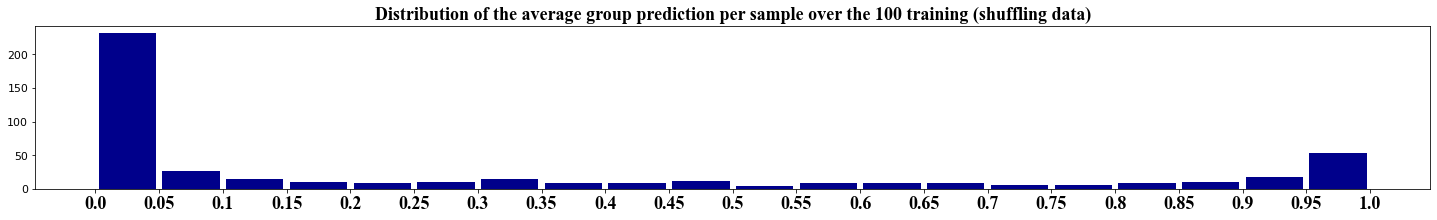

In [200]:
conslusiveness_score = performances_df.iloc[0]['y_pred']

fi(25, 3)
plt.hist(conslusiveness_score, bins=np.arange(0, 1.05, .05), color='darkblue', rwidth = 0.9)
plt.title("Distribution of the average group prediction per sample over the 100 training (shuffling data)", weight='bold', fontsize=18, **csfont)
plt.xticks(np.arange(0, 1.05, .05), np.round(np.arange(0, 1.05, .05), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.xticks(np.arange(0, 1.05, .05), np.round(np.arange(0, 1.05, .05), 2).astype(str), weight='bold', fontsize=18, **csfont)
#plt.savefig(os.path.join(ROOT_DIR, 'figures', 'conclusiveness.png'), dpi=200, bbox_inches = 'tight')
None

In [201]:
from utils import compute_performances_operating_points
df_breakdown_results = compute_performances_operating_points(y_true=y_true, y_pred=conslusiveness_score)

df_breakdown_results.to_csv("/home01/sam/notes_on_stats/doc/src/data/dataframe/operating_points_ddld_multimodal_paper.csv", index=False)

In [ ]:
#df = create_autism_df(folder_names = ['24_Janvier_Final_Importance_Computation_with_pwb_ddld_depth_5_test_1'])#'13_november_bis'])#'November 2022'])
df = create_autism_df(folder_names = ['54_Janvier_Final_Importance_Computation_ddld_without_weight'])#'13_november_bis'])#'November 2022'])


# With BLink without weight with pwb DDLD depth 3 200 est loocv
display(df[['AUROC', 'Sensitivity', 'Specificity']].mean())


conslusiveness_score = []
for i, row in df.iterrows():

    y_true = row['y_true'][0]
    y_pred = row['y_pred'][0]
    conslusiveness_score.append(list((y_pred >row['optimal_threshold']).astype(int)))
conslusiveness_score = np.array(conslusiveness_score).mean(axis=0)

max_youden, index_threshold, optimal_threshold = find_optimal_threshold_youden(y_true, conslusiveness_score )
display(compute_results(y_true, conslusiveness_score, optimal_threshold)[['AUROC', 'Sensitivity, recall, hit rate, or true positive rate (TPR)', 'Specificity, selectivity or true negative rate (TNR)']])

In [ ]:
display(compute_results(y_true, conslusiveness_score, optimal_threshold)#[['AUROC', 'Sensitivity, recall, hit rate, or true positive rate (TPR)', 'Specificity, selectivity or true negative rate (TNR)']])

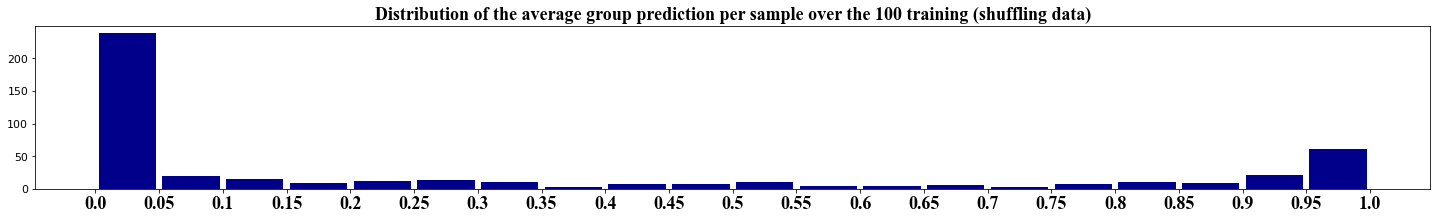

In [143]:
fi(25, 3)
plt.hist(conslusiveness_score, bins=np.arange(0, 1.05, .05), color='darkblue', rwidth = 0.9)
plt.title("Distribution of the average group prediction per sample over the 100 training (shuffling data)", weight='bold', fontsize=18, **csfont)
plt.xticks(np.arange(0, 1.05, .05), np.round(np.arange(0, 1.05, .05), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.xticks(np.arange(0, 1.05, .05), np.round(np.arange(0, 1.05, .05), 2).astype(str), weight='bold', fontsize=18, **csfont)
#plt.savefig(os.path.join(ROOT_DIR, 'figures', 'conclusiveness.png'), dpi=200, bbox_inches = 'tight')
None

**Computation of the average Shap values (no normalisation yet)**

In [99]:
exp_path = '/home01/sam/notes_on_stats/doc/src/data/54_Janvier_Final_Importance_Computation_ddld_without_weight/SenseToKnow/'

json_paths = glob(os.path.join(exp_path, '*', 'experiment*.json'))
i = 0
shap_interactions_all_cv = []
for json_path in json_paths:
    #try:
        
    with open(json_path, 'r') as f:
        data = json.load(f)

    shap_interactions_all_cv.append([np.array(data['shap_interaction_value'])])


shap_interactions = np.concatenate(shap_interactions_all_cv)
shap_interactions.shape

(100, 475, 23, 23)

**Computation of the feature impotance by summing over the interactions effect**

In [100]:
shap_values = shap_interactions.sum(axis=2)
shap_values.shape

(100, 475, 23)

**Normalization of the Shap values for each individuals so that the Shap values are comparable, given that they come from differet models being trained.**

In [101]:
shap_values_n = shap_values / np.abs(shap_values).sum(axis=2)[:, :, np.newaxis]

np.abs(shap_values_n[0, 0]).sum()

0.9999999999999999

**For a random individual this shows the fluctuations of their Shap values over different training step of the Cross-Validation**

The fluctuations we observe are due to the models differences when training it using different set of training data when the random sample is among the test set. Ideally if the model does not overfit the data and is robust, we should not see significant fluctuations

Subject:192


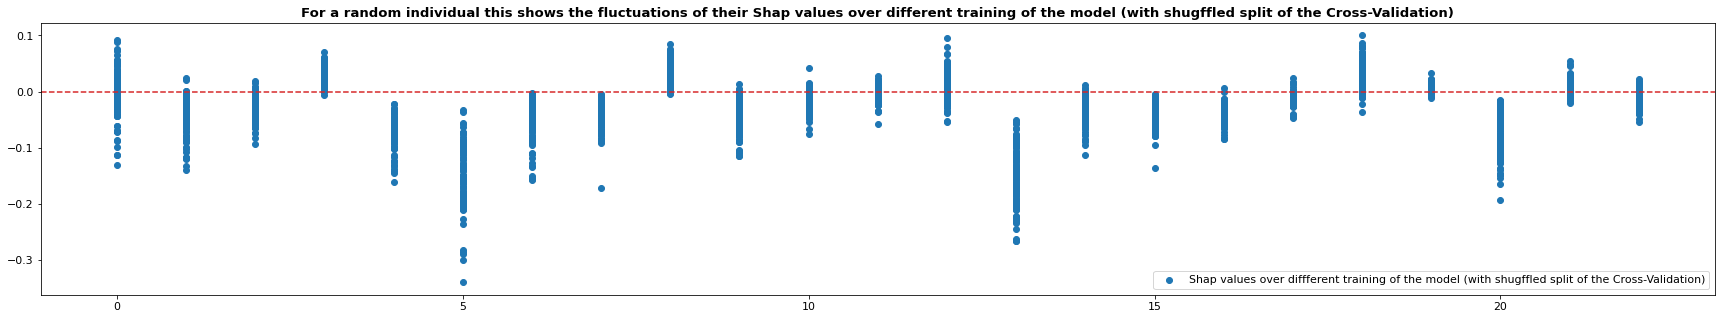

In [102]:
subject_of_interest = np.random.randint(shap_interactions.shape[1])
print("Subject:{}".format(subject_of_interest))

fi(30, 5)
n_model = shap_interactions.shape[0]
plt.title("For a random individual this shows the fluctuations of their Shap values over different training of the model (with shugffled split of the Cross-Validation)", weight='bold')
for i  in range(shap_interactions.shape[2]):
    plt.scatter([i]*n_model, shap_values_n[:, subject_of_interest, i], color='tab:blue', label="Shap values over diffferent training of the model (with shugffled split of the Cross-Validation)" if i==0 else None)
    
plt.axhline(0, linestyle='--', color='tab:red')
_ = plt.legend()


**Now we average the shap values over the K (=50)  training that were performed.**

In [103]:
shap_values_n.shape

(100, 475, 23)

**Averaging the Shap values over the different training**

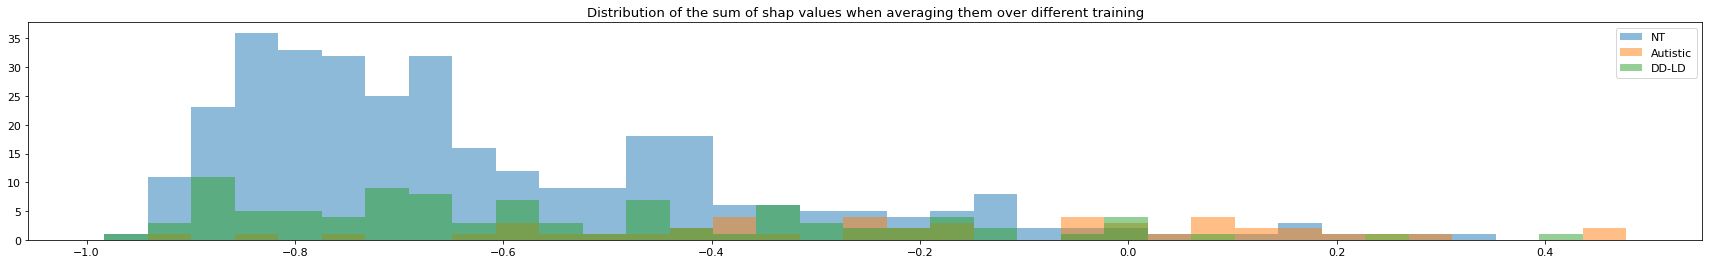

In [140]:
shap_values_averaged = shap_values_n.mean(axis=0)

fi(30, 4)
plt.title("Distribution of the sum of shap values when averaging them over different training")
_, _, _ = plt.hist(shap_values_averaged[i_nt].sum(axis=1), bins=bins, label='NT',alpha=.5, color='tab:blue')
_, _, _ = plt.hist(shap_values_averaged[i_asd].sum(axis=1), bins=bins,  label='Autistic',alpha=.5, color='tab:orange')
_, _, _ = plt.hist(shap_values_averaged[i_ddld].sum(axis=1), bins=bins,  label='DD-LD',alpha=.5, color='tab:green')


_  = plt.legend()

**Note that the Shap values of the samples are no longer normalized because of the averaging over different training, see here the average sum of absolute shap values:**

In [106]:
np.abs(shap_values_averaged).sum(axis=1).mean()

0.9061235175448061

**We therefore renormalize them**

In [107]:
shap_values_averaged_n = shap_values_averaged / np.abs(shap_values_averaged).sum(axis=1)[:, np.newaxis]
np.abs(shap_values_averaged_n).sum(axis=1).mean()

1.0

**We now check that the final Shap values for 5 random samples are consistent with what we can observe during a random taining for a sample**

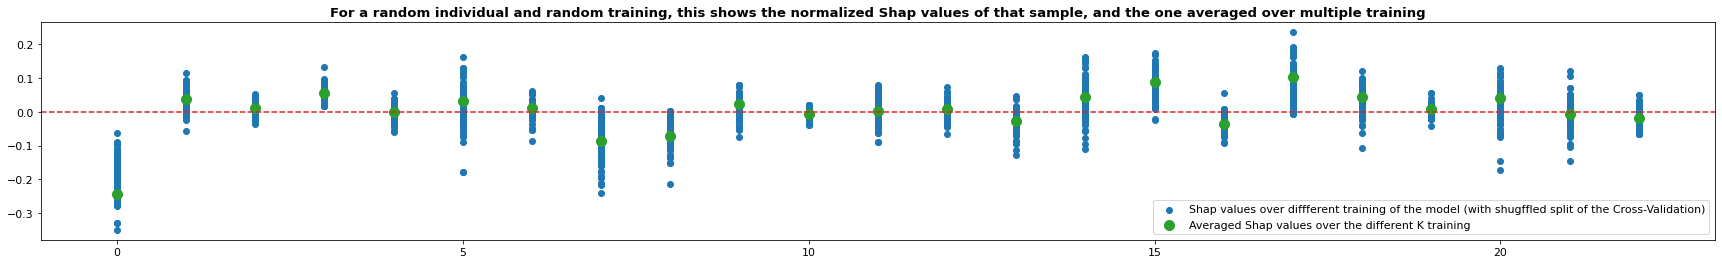

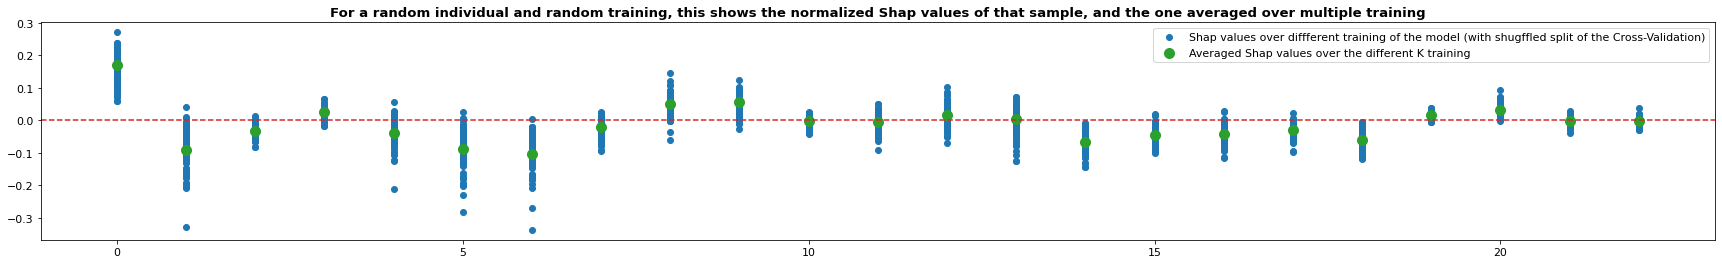

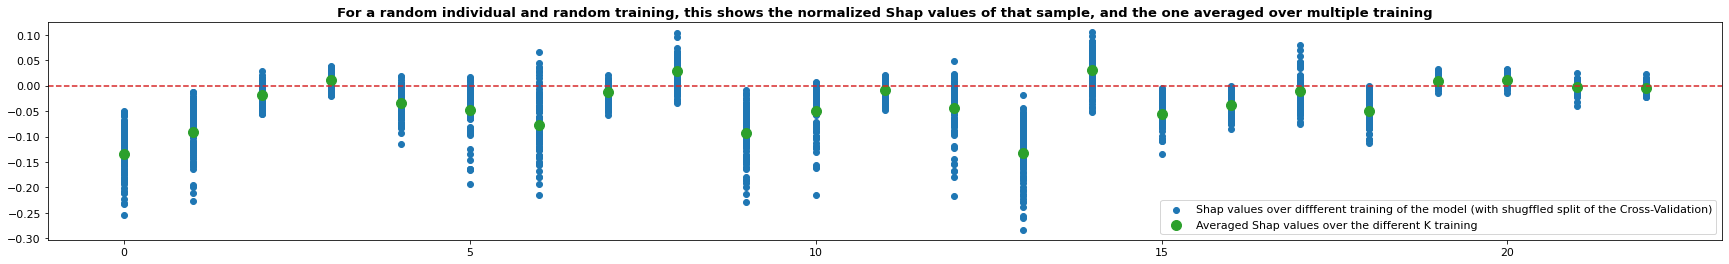

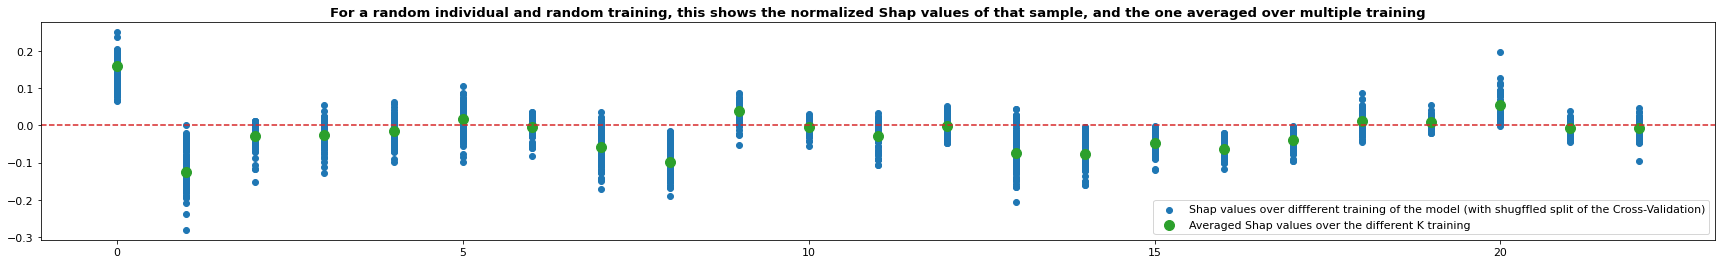

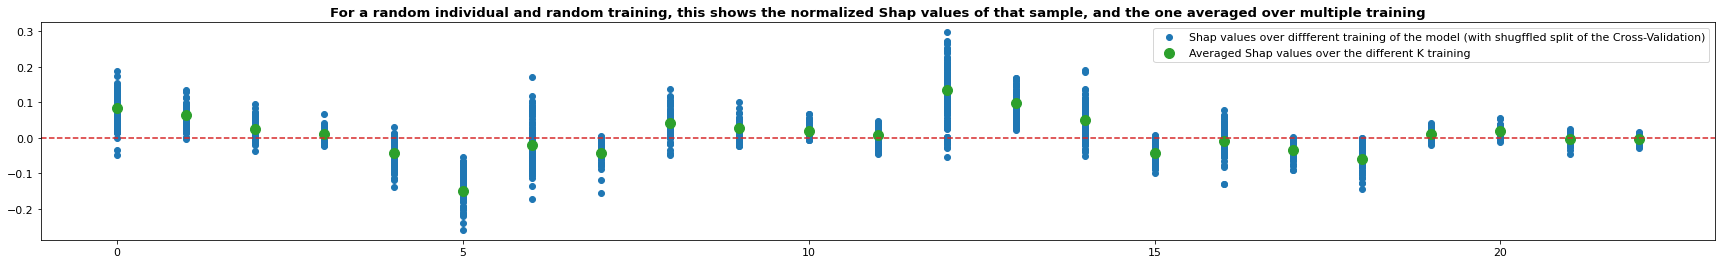

In [108]:
random_samples =  np.random.randint(0, shap_values_n.shape[1], 5)


for random_sample in random_samples:

    n_training = shap_values_n.shape[0]
    fi(30, 4)
    plt.title("For a random individual and random training, this shows the normalized Shap values of that sample, and the one averaged over multiple training", weight='bold')
    for i  in range(shap_values_averaged_n.shape[1]):
        plt.scatter([i]*n_training, shap_values_n[:, random_sample, i], color='tab:blue', label="Shap values over diffferent training of the model (with shugffled split of the Cross-Validation)" if i==0 else None)
        plt.scatter([i], shap_values_averaged_n[random_sample, i], color='tab:green', s=100, label="Averaged Shap values over the different K training" if i==0 else None)
    plt.axhline(0, linestyle='--', color='tab:red')
    plt.legend()
    plt.show()

**At this point, `shap_values_averaged_n` contains the Shap Values of the final sample.** 

- We can compute the compliance score
- We could plot the final Shap values importance but we need to see if sampling will be improving

In [109]:
np.save(os.path.join(DATA_DIR, 'multimodal_paper', 'Average_normalized_Shap_values_regular_sample_before_weighting_ddld.npy'), shap_values_averaged_n)

# Computation of the shapley values acccounting for features missingness.

For each of the stored Shap values (i.e. the attribution of features importance on each sample), some might be associated to the contribution of the feature being missing, if for that sample the feature were actually missing.
In order to put things in order and disentangled to importance of the features values and their missingness, we here set to 0 the shapley value asociated to missing feature (HYP: the underlying hypothesis of doing that is that if a value is unknown, its contribution should be 0, and rather what should have this contrinution is the missingness of that variable).

*Notes*
- Given that the shap values was collected on each sample using cross-validation, i.e training a different model every time, we cannot compare or average the shap values directly. We first need to normalize each shap values $(\phi_k^i)_{k \in [1, K]}$ for $i \in [1, N]$. Since the sign is informative we still conserve it. 
- We verify that the features themselves have higher importance than their missingness.
- To compute the global importance of each of the features (when there are known, not when we miss them), we proceed as follows:
    1) First we only take into account the first half of the `general_shap_values_normalized` (features attribution when the values are know)

In [110]:
print("{} missing values".format((np.isnan(exp.dataset._X_train)).astype(int).sum()))

1200 missing values


In [111]:
shap_values_averaged_n.shape

(475, 23)

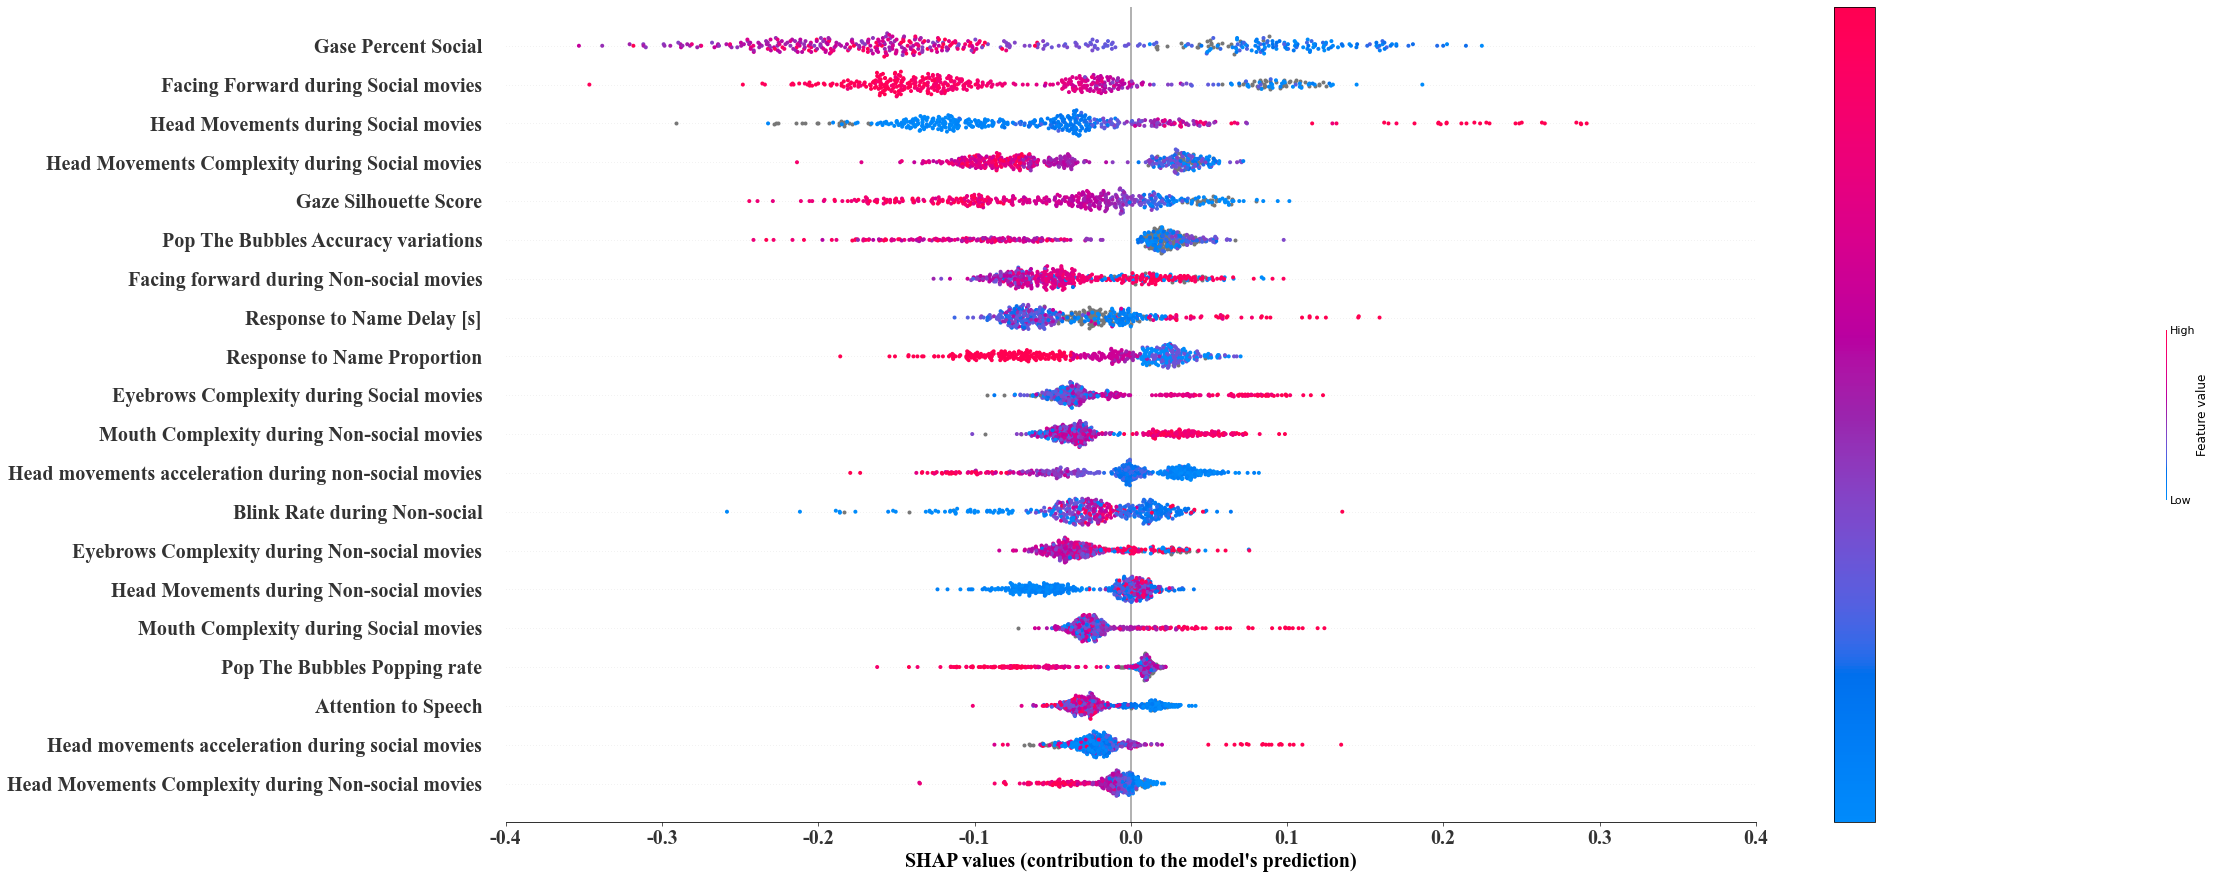

In [112]:
import shap
fig = shap.summary_plot(shap_values_averaged_n, exp.dataset._X_train, feature_names = [feature_name_mapping[f] for f in exp.features_name], plot_size=(35, 15), show=False)# plot_type='bar')

ax= plt.gca()
list_labels = [l._text for l in  ax.get_yticklabels()]
ax.set_yticks(ax.get_yticks(), list_labels, weight='bold', fontsize=20, **csfont)
ax.set_xticks(ax.get_xticks(), np.round(ax.get_xticks(), 2).astype(str), weight='bold', fontsize=20, **csfont)
ax.set_xlabel("SHAP values (contribution to the model's prediction)", weight='bold', fontsize=20, **csfont)
      
ax.set_facecolor('white')
plt.gcf().patch.set_facecolor('white')
plt.colorbar(ticks=range(6), label='')

plt.savefig(os.path.join(ROOT_DIR, 'figures', 'features_importance_ddld.png'), dpi=200, bbox_inches = 'tight', facecolor=plt.gcf().get_facecolor(), edgecolor='none')

In [113]:
[(feat, val) for feat, val in zip(exp.features_name, np.round(np.abs(shap_values_averaged_n).mean(axis=0)*100, 2))]

[('mean_gaze_percent_right', 13.89),
 ('gaze_silhouette_score', 5.89),
 ('FP_gaze_speech_correlation', 2.62),
 ('proportion_of_name_call_responses', 4.32),
 ('average_response_to_name_delay', 4.48),
 ('S_postural_sway', 8.49),
 ('NS_postural_sway', 3.0),
 ('S_postural_sway_derivative', 2.59),
 ('NS_postural_sway_derivative', 3.71),
 ('S_postural_sway_complexity', 6.11),
 ('NS_postural_sway_complexity', 1.63),
 ('S_blink_rate', 1.14),
 ('NS_blink_rate', 3.54),
 ('S_facing_forward', 9.95),
 ('NS_facing_forward', 4.78),
 ('S_eyebrows_complexity', 4.09),
 ('NS_eyebrows_complexity', 3.39),
 ('S_mouth_complexity', 2.93),
 ('NS_mouth_complexity', 3.83),
 ('pop_rate', 2.78),
 ('std_error', 5.36),
 ('average_length', 0.86),
 ('average_force_applied', 0.64)]

**We now disembiguate the missing and present shap valeus for each samples using masking**

In [114]:
mask_shap_present = (~np.isnan(exp.dataset._X_train)).astype(int)
shap_present = np.multiply(shap_values_averaged_n, mask_shap_present)
shap_missing = np.multiply(shap_values_averaged_n, (mask_shap_present==0).astype(int))

**Concatenate shap value separating real variables and when there are missing. Note that we did not lost the normalization**

In [115]:
general_shap_values = np.concatenate([shap_present, shap_missing], axis=1)

np.abs(general_shap_values).sum(axis=1).mean()

1.0

**We now normalize the absolute Shap values over samples, and average them, to have the Final features importances per variables + per missingness.**

In [116]:
general_shap_values_normalized = np.abs(general_shap_values)/ np.abs(general_shap_values).sum(axis=1)[:, np.newaxis]


In [117]:
features_importances_extended = general_shap_values_normalized.sum(axis=0)/general_shap_values_normalized.sum()
np.abs(features_importances_extended).sum(axis=0)

1.0

**We now visualize the features contribution of the present variables and the contributions of the missing ones**

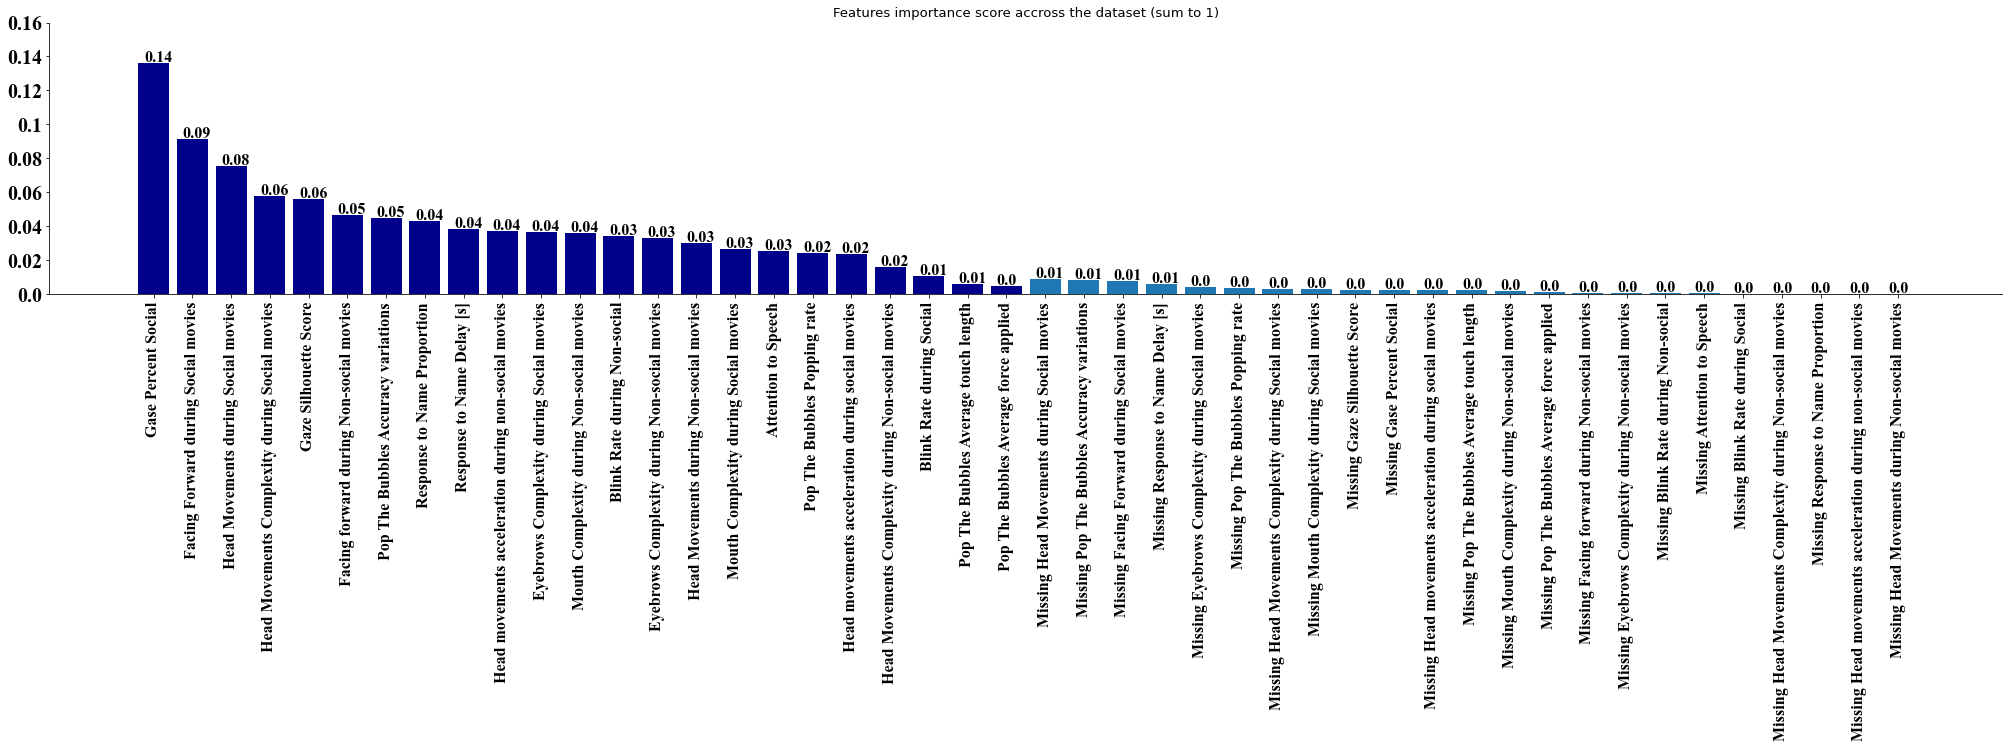

In [118]:
labels = exp.features_name + ["Z_{}".format(feat_name) for feat_name in exp.features_name]       
n_features = len(exp.features_name)

#We first plot the present ones
idx_sorting_present = list(reversed(np.argsort(features_importances_extended[:n_features])))
offset=0.001
fi(35, 5)
plt.title("Features importance score accross the dataset (sum to 1)")
for i, feat in enumerate(np.array(exp.features_name)[idx_sorting_present]):
    plt.bar(i, features_importances_extended[idx_sorting_present][i], color='darkblue')
    plt.annotate(str(np.round(features_importances_extended[idx_sorting_present][i], 2)), (i-.25, features_importances_extended[idx_sorting_present][i] + offset), weight='bold', fontsize=16, **csfont)
    
    
idx_sorting_missing = list(reversed(np.argsort(features_importances_extended[n_features:])))
idx_sorting_missing = list(np.array(idx_sorting_missing) + n_features)
#And then the missing ones
for i, feat in enumerate(np.array(labels)[idx_sorting_missing]):
    j = i + n_features
    plt.bar(j, features_importances_extended[idx_sorting_missing][i], color='tab:blue')
    plt.annotate(str(np.round(features_importances_extended[idx_sorting_missing][i], 2)), (j-.25, features_importances_extended[idx_sorting_missing][i] + offset), weight='bold', fontsize=16, **csfont)
    
idx_sorting = idx_sorting_present + idx_sorting_missing
plt.xticks(ticks = np.arange(features_importances_extended.shape[0]), labels= [feature_name_mapping[f] if f[0] != 'Z' else "Missing " + feature_name_mapping[f[2:]] for f in np.array(labels)[idx_sorting]], rotation =90, weight='bold', fontsize=16, **csfont)
#plt.xticks(ticks = np.arange(features_importances_extended.shape[0]), labels=[feature_name_mapping[f] for f in np.array(labels)[idx_sorting]], rotation =90)
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.gca().set_yticks(plt.gca().get_yticks(), np.round(plt.gca().get_yticks(), 2).astype(str), weight='bold', fontsize=20, **csfont)
plt.savefig(os.path.join(ROOT_DIR, 'figures', 'features_importance_present_missing_ddld.png'), dpi=200, bbox_inches = 'tight', facecolor=plt.gcf().get_facecolor(), edgecolor='none')


#percent_missing_importance_mean = (1 - features_importances_extended[:len(exp.features_name)].sum(axis=1)).mean()*100
#percent_missing_importance_std =(1 - features_importances_extended[:len(exp.features_name)].sum(axis=1)).std()*100

#print("The average (std) contribution of the variables being missing are: {:.2f}% (+/- {:.2f}%)".format(percent_missing_importance_mean, percent_missing_importance_std))

In [119]:
general_shap_values_normalized[:, len(exp.features_name):].sum(axis=1).std()

0.1462875861053292

**What is the global contribution to the missing variables to the model ?**

In [120]:
percent_missing_importance_mean = general_shap_values_normalized[:, len(exp.features_name):].sum(axis=1).mean()*100
percent_missing_importance_std = general_shap_values_normalized[:, len(exp.features_name):].sum(axis=1).std()*100

print("The average (std) contribution of the variables being missing are: {:.2f}% (+/- {:.2f}%)".format(percent_missing_importance_mean, percent_missing_importance_std))

The average (std) contribution of the variables being missing are: 6.38% (+/- 14.63%)


**Which feature missingness is the most important overall ?**

In [121]:
general_shap_values_normalized[:, len(exp.features_name):].mean(axis=0)

array([0.00247542, 0.00254947, 0.00087635, 0.00024608, 0.00630177,
       0.00912905, 0.        , 0.00243326, 0.        , 0.00306658,
       0.00029966, 0.00039241, 0.00092387, 0.00811574, 0.00099911,
       0.00412288, 0.00097292, 0.00283992, 0.00204782, 0.0036444 ,
       0.00847959, 0.00235056, 0.00157875])

In [122]:
general_shap_values_normalized[:, len(exp.features_name):].std(axis=0)

array([0.01155094, 0.01130971, 0.00377817, 0.00292047, 0.01293187,
       0.04187774, 0.        , 0.01114695, 0.        , 0.01017674,
       0.00155961, 0.00209328, 0.01180842, 0.02680266, 0.00577968,
       0.0137711 , 0.00511397, 0.00952718, 0.01027075, 0.00535039,
       0.01272446, 0.00472441, 0.0027723 ])

In [123]:
exp.features_name[11]

'S_blink_rate'

**Which feature missingness is the most important overall ? Now we detail the analysis only accounting for the participants having the feature missing (for each feature). This allow for instance to say: among all the participant who miss feature X, the average contribution of missing this feature where Y.**

In [114]:
mean_contribution_missing = [] 
std_contribution_missing = []
for i, feature_name in enumerate(exp.features_name):
    print(feature_name, len(np.argwhere(np.isnan(exp.dataset._X_train[:, i])).flatten()))
    
    
    
    mean_contribution_missing.append(general_shap_values_normalized[:, len(exp.features_name):][np.argwhere(np.isnan(exp.dataset._X_train[:, i])).flatten(), i].mean())
    std_contribution_missing.append(general_shap_values_normalized[:, len(exp.features_name):][np.argwhere(np.isnan(exp.dataset._X_train[:, i])).flatten(), i].std())

mean_contribution_missing = np.array(mean_contribution_missing)
mean_contribution_missing[np.isnan(np.array(mean_contribution_missing))] = 0


std_contribution_missing = np.array(std_contribution_missing)
std_contribution_missing[np.isnan(np.array(std_contribution_missing))] = 0

mean_gaze_percent_right 24
gaze_silhouette_score 24
FP_gaze_speech_correlation 28
proportion_of_name_call_responses 4
average_response_to_name_delay 118
S_postural_sway 22
NS_postural_sway 0
S_postural_sway_derivative 22
NS_postural_sway_derivative 0
S_postural_sway_complexity 42
NS_postural_sway_complexity 20
S_blink_rate 28
NS_blink_rate 3
S_facing_forward 41
NS_facing_forward 20
S_eyebrows_complexity 42
NS_eyebrows_complexity 20
S_mouth_complexity 42
NS_mouth_complexity 20
pop_rate 167
std_error 173
average_length 167
average_force_applied 173


In [115]:
mean_contribution_missing

array([0.05357651, 0.050817  , 0.01627778, 0.03101455, 0.02205659,
       0.19587599, 0.        , 0.0467692 , 0.        , 0.0370709 ,
       0.00607968, 0.00473921, 0.1621579 , 0.09162684, 0.02533321,
       0.04569226, 0.0226763 , 0.03170523, 0.0518766 , 0.01121281,
       0.02542138, 0.00539599, 0.00311838])

In [116]:
general_shap_values_normalized[:, len(exp.features_name):].std(axis=0)

array([0.01253967, 0.01136063, 0.00419747, 0.00311701, 0.0115822 ,
       0.04170687, 0.        , 0.00997138, 0.        , 0.01093634,
       0.00139323, 0.00153851, 0.01323753, 0.02613272, 0.00631076,
       0.01361294, 0.00520673, 0.00945512, 0.01099468, 0.00579871,
       0.01394847, 0.00402738, 0.00222153])

In [117]:
exp.features_name[14]

'NS_facing_forward'

**Conclusion:**

When missing, it is the Eyebrows complexity (missing)  that were themost important, with an average contribution of around 15%. However, this only concerns 4 cases...

0.13663403617279396

**For the computation of the compliance score, we are now interested only in the features that are present, and without the indicator variables.**

There are not normalized so we first need to renormalized them (some importance were allocated to the missing variables and Z)

In [125]:
shap_present_real_variables = shap_present[:, :23]
np.abs(shap_present_real_variables).sum(axis=1).mean()

0.9361544120506408

In [126]:
shap_present_normalized = np.abs(shap_present_real_variables) / np.abs(shap_present_real_variables).sum(axis=1)[:, np.newaxis] 
np.abs(shap_present_normalized).sum(axis=1).mean()

1.0

**We now average over the participants to get th importance of the present variables to the model**

In [127]:
features_importance_present_n = np.abs(shap_present_normalized).sum(axis=0)/ np.abs(shap_present_normalized).sum()
features_importance_present_n.shape

(23,)

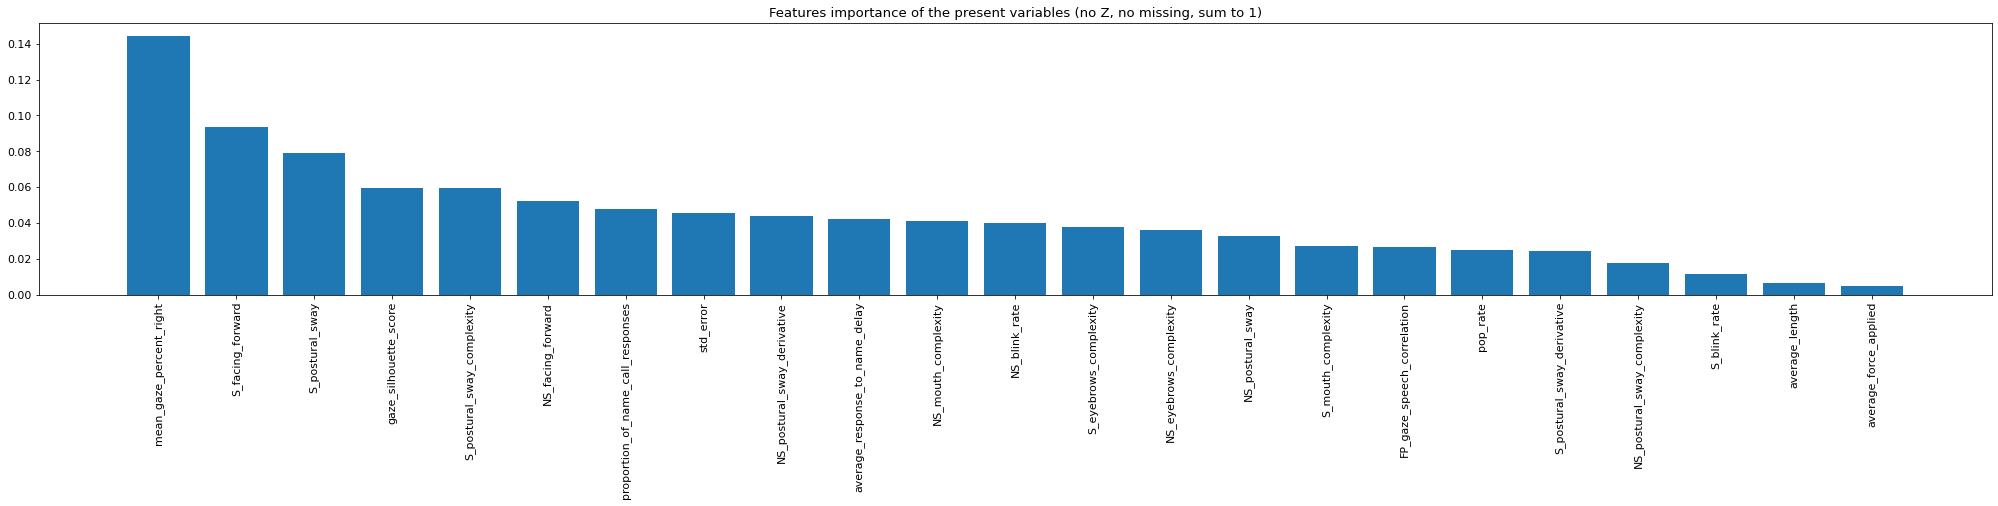

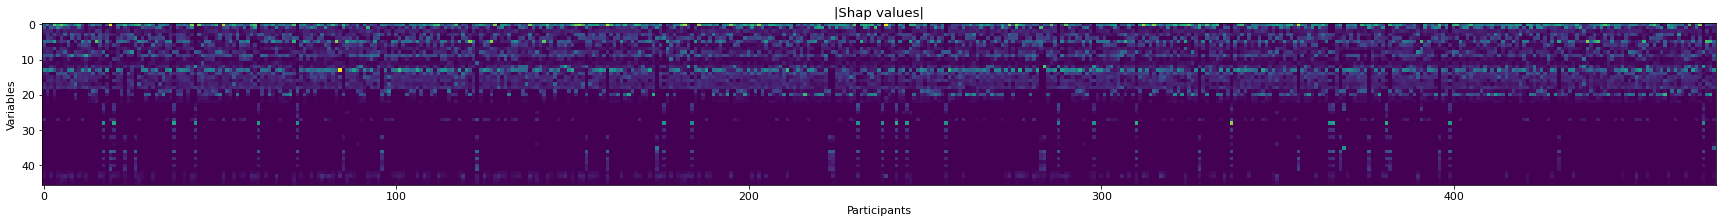

In [128]:
idx_ordered = list(reversed(np.argsort(features_importance_present_n)))

fi(35, 5)
plt.title("Features importance of the present variables (no Z, no missing, sum to 1)")
for i, (idx, feat) in enumerate(zip(idx_ordered, np.array(exp.features_name[:23])[idx_ordered])):
    plt.bar(i, features_importance_present_n[idx], color='tab:blue')
plt.xticks(ticks = np.arange(features_importance_present_n.shape[0]), labels=np.array(exp.features_name[:23])[idx_ordered], rotation =90)
None


fi(30, 35)
plt.title("|Shap values|")
plt.imshow(general_shap_values_normalized.transpose())
plt.xlabel("Participants")
plt.ylabel("Variables")   
None

**We can store the importance of each of the features to the model**

This is super useful when we extend the cohort or use the DDLD, we can therefore directly use this, the confidence score of each snew samples (computed from their available data), and so compute the compiance score of each participant. 

In [129]:
features_importance_present_n

array([0.14446654, 0.05965288, 0.02635112, 0.04786444, 0.04243791,
       0.07880654, 0.03276698, 0.02454041, 0.04383582, 0.05940421,
       0.01767455, 0.01181633, 0.04023311, 0.09378591, 0.05240862,
       0.03762968, 0.0360917 , 0.02712598, 0.04092287, 0.02507402,
       0.0457468 , 0.00644008, 0.0049235 ])

In [130]:
np.save(os.path.join(DATA_DIR, 'multimodal_paper', 'features_importance_present_n_ddld.npy'), features_importance_present_n)

# Building W the matrix of confidence in the different measure


In this section we aim at weighting the confidence we have in each of the input. The weight are between 0 and 1. This is an initial potentially naive way ay of weigthing the features confidences.
- For features that are an aggregation of the same feature over multiple videos, we use linear weighting (1 is all measures are available 0 otherwise, with linear mapping between these extremes).
- For the name call variables, we use the number of valid name call experiemnts. This can be 0, 1, 2, or 3. If 0 valid name call experiment, we set the weigths to 0. If there are at least one valid experiement, we still may or not ghave the information of the delay. In this case there are two scenraio that have been discussed. Either the participant answered and so the weighting is the same as the proportion of valid name call. If the participant did not answer, there is no "delay experiment", and so we set it to 0 (and not to the proportion...).
- For the touch variables, a measure of confidence we may have on the different variables could be proportional to the number of touches, with a maxmum confidence when the number of touches is higher than e.g. 15. 

For missing features, we let their weight to be 0, as we don't have the information of their value, but set to 1 the weight attributed to the indicator variable of its missingness (as xgboost handles missing data, it still uses the information of that feature being missing, so this information is accouted for).


There are two ways we can use these weights. 
1) During training and inference, we weight the input matrix by these weights, which influence the weighting of the gradient and hessian statiastics of the different optimization steps. 
2) More complex, using Bayesian ideas. We can see the input features as gaussians, with for instance a sigma parameter close to 0 if we have some certainty about the measure, and larger (value depends on the feature range etc), for input we are not to sure about.



In [131]:

if True:
    
    exp.dataset.df['S_blink_rate_conf'] = (~exp.dataset.df[['MML_blink_rate', 'FP_blink_rate', 'PWB_blink_rate']].isna()).sum(axis=1)/3
    exp.dataset.df['NS_blink_rate_conf'] = (~exp.dataset.df[['DIGC_blink_rate', 'DIGRRL_blink_rate', 'FB_blink_rate', 'MP_blink_rate']].isna()).sum(axis=1)/4

    
    exp.dataset.df['S_postural_sway_conf'] = (~exp.dataset.df[['ST_postural_sway', 'BB_postural_sway', 'MML_postural_sway', 'FP_postural_sway', 'PWB_postural_sway']].isna()).sum(axis=1)/5
    exp.dataset.df['NS_postural_sway_conf'] = (~exp.dataset.df[['DIGC_postural_sway', 'DIGRRL_postural_sway', 'FB_postural_sway', 'MP_postural_sway']].isna()).sum(axis=1)/4
   
    exp.dataset.df['S_postural_sway_derivative_conf'] = (~exp.dataset.df[['ST_postural_sway_derivative', 'BB_postural_sway_derivative', 'MML_postural_sway_derivative', 'FP_postural_sway_derivative', 'PWB_postural_sway_derivative']].isna()).sum(axis=1)/5
    exp.dataset.df['NS_postural_sway_derivative_conf'] = (~exp.dataset.df[['DIGC_postural_sway_derivative', 'DIGRRL_postural_sway_derivative', 'FB_postural_sway_derivative', 'MP_postural_sway_derivative']].isna()).sum(axis=1)/4
    
    exp.dataset.df['gaze_silhouette_score_conf'] = (~exp.dataset.df[['BB_gaze_silhouette_score','S_gaze_silhouette_score']].isna()).sum(axis=1)/2
    exp.dataset.df['mean_gaze_percent_right_conf'] = (~exp.dataset.df[['S_gaze_percent_right','BB_gaze_percent_right']].isna()).sum(axis=1)/2
    exp.dataset.df['FP_gaze_speech_correlation_conf'] = (~exp.dataset.df[['FP_gaze_speech_correlation']].isna()).sum(axis=1)

    exp.dataset.df['S_facing_forward_conf'] = (~exp.dataset.df[['ST_facing_forward', 'BB_facing_forward', 'MML_facing_forward', 'FP_facing_forward', 'PWB_facing_forward']].isna()).sum(axis=1)/5
    exp.dataset.df['NS_facing_forward_conf'] = (~exp.dataset.df[['DIGC_facing_forward', 'DIGRRL_facing_forward', 'FB_facing_forward', 'MP_facing_forward']].isna()).sum(axis=1)/4

    exp.dataset.df['S_eyebrows_complexity_conf'] = (~exp.dataset.df[['ST_eyebrows_complexity', 'BB_eyebrows_complexity', 'MML_eyebrows_complexity', 'FP_eyebrows_complexity', 'PWB_eyebrows_complexity']].isna()).sum(axis=1)/5
    exp.dataset.df['NS_eyebrows_complexity_conf'] = (~exp.dataset.df[['DIGC_eyebrows_complexity', 'DIGRRL_eyebrows_complexity', 'FB_eyebrows_complexity', 'MP_eyebrows_complexity']].isna()).sum(axis=1)/4

    exp.dataset.df['S_mouth_complexity_conf'] = (~exp.dataset.df[['ST_mouth_complexity', 'BB_mouth_complexity', 'MML_mouth_complexity', 'FP_mouth_complexity', 'PWB_mouth_complexity']].isna()).sum(axis=1)/5
    exp.dataset.df['NS_mouth_complexity_conf'] = (~exp.dataset.df[['DIGC_mouth_complexity', 'DIGRRL_mouth_complexity', 'FB_mouth_complexity', 'MP_mouth_complexity']].isna()).sum(axis=1)/4

    exp.dataset.df['S_postural_sway_complexity_conf'] = (~exp.dataset.df[['ST_head_movement_complexity', 'BB_head_movement_complexity', 'MML_head_movement_complexity', 'FP_head_movement_complexity', 'PWB_head_movement_complexity']].isna()).sum(axis=1)/5
    exp.dataset.df['NS_postural_sway_complexity_conf'] = (~exp.dataset.df[['DIGC_head_movement_complexity', 'DIGRRL_head_movement_complexity', 'FB_head_movement_complexity', 'MP_head_movement_complexity']].isna()).sum(axis=1)/4


    exp.dataset.df['RTN_conf'] = exp.dataset.df['valid_name_calls'].apply(lambda x: np.sum(x))/3
    exp.dataset.df['touch_conf'] = exp.dataset.df['number_of_touches'].apply(lambda x: 0 if np.isnan(x) else x/15  if x <=15 else 1. if x>= 16 else 0)




if False:

    exp.dataset.df['S_postural_sway_conf'] = (~exp.dataset.df[['ST_postural_sway', 'BB_postural_sway', 'MML_postural_sway', 'FP_postural_sway']].isna()).sum(axis=1)/4
    exp.dataset.df['NS_postural_sway_conf'] = (~exp.dataset.df[['DIGC_postural_sway', 'DIGRRL_postural_sway', 'FB_postural_sway', 'MP_postural_sway']].isna()).sum(axis=1)/4
    exp.dataset.df['S_postural_sway_derivative_conf'] = (~exp.dataset.df[['ST_postural_sway_derivative', 'BB_postural_sway_derivative', 'MML_postural_sway_derivative', 'FP_postural_sway_derivative']].isna()).sum(axis=1)/4
    exp.dataset.df['NS_postural_sway_derivative_conf'] = (~exp.dataset.df[['DIGC_postural_sway_derivative', 'DIGRRL_postural_sway_derivative', 'FB_postural_sway_derivative', 'MP_postural_sway_derivative']].isna()).sum(axis=1)/4
    exp.dataset.df['gaze_silhouette_score_conf'] = (~exp.dataset.df[['BB_gaze_silhouette_score','S_gaze_silhouette_score']].isna()).sum(axis=1)/2
    exp.dataset.df['mean_gaze_percent_right_conf'] = (~exp.dataset.df[['S_gaze_percent_right','BB_gaze_percent_right']].isna()).sum(axis=1)/2
    exp.dataset.df['FP_gaze_speech_correlation_conf'] = (~exp.dataset.df[['FP_gaze_speech_correlation']].isna()).sum(axis=1)

    exp.dataset.df['S_facing_forward_conf'] = (~exp.dataset.df[['ST_facing_forward', 'BB_facing_forward', 'MML_facing_forward', 'FP_facing_forward']].isna()).sum(axis=1)/4
    exp.dataset.df['NS_facing_forward_conf'] = (~exp.dataset.df[['DIGC_facing_forward', 'DIGRRL_facing_forward', 'FB_facing_forward', 'MP_facing_forward']].isna()).sum(axis=1)/4

    exp.dataset.df['S_eyebrows_complexity_conf'] = (~exp.dataset.df[['ST_eyebrows_complexity', 'BB_eyebrows_complexity', 'MML_eyebrows_complexity', 'FP_eyebrows_complexity']].isna()).sum(axis=1)/4
    exp.dataset.df['NS_eyebrows_complexity_conf'] = (~exp.dataset.df[['DIGC_eyebrows_complexity', 'DIGRRL_eyebrows_complexity', 'FB_eyebrows_complexity', 'MP_eyebrows_complexity']].isna()).sum(axis=1)/4

    exp.dataset.df['S_mouth_complexity_conf'] = (~exp.dataset.df[['ST_mouth_complexity', 'BB_mouth_complexity', 'MML_mouth_complexity', 'FP_mouth_complexity']].isna()).sum(axis=1)/4
    exp.dataset.df['NS_mouth_complexity_conf'] = (~exp.dataset.df[['DIGC_mouth_complexity', 'DIGRRL_mouth_complexity', 'FB_mouth_complexity', 'MP_mouth_complexity']].isna()).sum(axis=1)/4

    exp.dataset.df['S_postural_sway_complexity_conf'] = (~exp.dataset.df[['ST_head_movement_complexity', 'BB_head_movement_complexity', 'MML_head_movement_complexity', 'FP_head_movement_complexity']].isna()).sum(axis=1)/4
    exp.dataset.df['NS_postural_sway_complexity_conf'] = (~exp.dataset.df[['DIGC_head_movement_complexity', 'DIGRRL_head_movement_complexity', 'FB_head_movement_complexity', 'MP_head_movement_complexity']].isna()).sum(axis=1)/4


    exp.dataset.df['RTN_conf'] = exp.dataset.df['valid_name_calls'].apply(lambda x: np.sum(x))/3
    exp.dataset.df['touch_conf'] = exp.dataset.df['number_of_touches'].apply(lambda x: 0 if np.isnan(x) else x/15  if x <=15 else 1. if x>= 16 else 0)


for conf_col in ['S_postural_sway_conf', 'NS_postural_sway_conf', 'S_postural_sway_derivative_conf', 'NS_postural_sway_derivative_conf',
                 'gaze_silhouette_score_conf', 'mean_gaze_percent_right_conf', 'proportion_of_name_call_responses_conf', 'average_response_to_name_delay_conf', 'touch_conf']:
    
    pass#exp.dataset.df.loc[exp.dataset.df[conf_col]==0, conf_col] = 1
    

conf_values = np.zeros((exp.dataset.num_samples, len(DEFAULT_PREDICTORS)))

for i, feat in enumerate(DEFAULT_PREDICTORS):
    
    if feat in TOUCH_VARIABLES:
        
        # These features don't depend on the number of touches, it is a value that we measures and so its confidence should be 1. 
        # We weight only the features that depend on the number of features.
        if feat in ['number_of_touches', 'number_of_target']:
            
            conf_values[:, i] = (~np.isnan(exp.dataset._X_train[:,i])).astype(int)
        
        else:
            
            conf_values[:, i] = (~np.isnan(exp.dataset._X_train[:,i])).astype(int) * exp.dataset.df['touch_conf']
        
    elif feat == 'proportion_of_name_call_responses':
        
        conf_values[:, i] = exp.dataset.df['RTN_conf']
        
    elif feat == 'average_response_to_name_delay':
        
        # 0 if the delay is missing, the proportion of valid  name calls otherwise
        
        conf_values[:, i] = (~np.isnan(exp.dataset._X_train[:,i])).astype(int) * exp.dataset.df['RTN_conf']
            
    else:
        conf_values[:, i] = exp.dataset.df['{}_conf'.format(feat)]
        
    

In [61]:
    
# ----------------- Shanity check: show the values that are missing but don't have a confidence set to 0 (should not be the case) -----------------------
# Pour toutes les nan des features
for coord in np.argwhere((mask_shap_present.astype(int)==0).astype(int) == 1):
    
    # Est-ce que la matrice de W est bien 0 ? 
    if conf_values[coord[0]][coord[1]] != 0 :
        print(coord, conf_values[coord[0]][coord[1]], exp.dataset._X_train[coord[0]][coord[1]])
        
        
# ----------------- Shanity check: show the values that have a confidence of 0 but are not msising (should only be the case for the RTN delay if no valid NC) -----------------------
# Pour toutes les nan des features
for coord in np.argwhere(conf_values==0):
    
    # Est-ce que la matrice de W est bien 0 ? 
    if not np.isnan(exp.dataset._X_train[coord[0]][coord[1]]):
        if exp.features_name[coord[1]] != 'average_response_to_name_delay':
            print(coord, exp.dataset._X_train[coord[0]][coord[1]], exp.features_name[coord[1]])
            
            

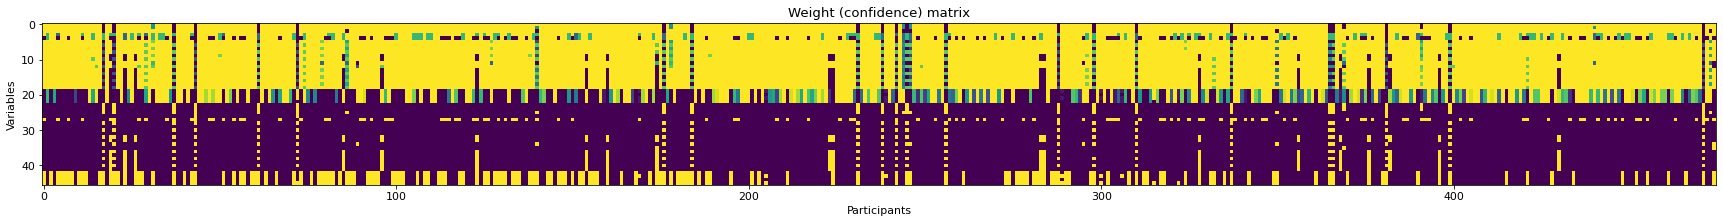

In [133]:
            
# --------------- Add the weights asssociated with the missingness ---------------------- #
conf_values = np.concatenate([conf_values, np.isnan(exp.dataset._X_train).astype(int)], axis=1)

fi(30, 35)
plt.title("Weight (confidence) matrix")
plt.imshow(conf_values.transpose())
plt.xlabel("Participants")
plt.ylabel("Variables")   
None

In [85]:
# Experimental ...

#exp.dataset.df['Measures Confidence Uniform'] = exp.dataset.df[['S_postural_sway_conf', 'NS_postural_sway_conf', 'S_postural_sway_derivative_conf',
#                                                        'NS_postural_sway_derivative_conf', 'gaze_silhouette_score_conf', 'mean_gaze_percent_right_conf', 
 #                                                       'RTN_conf', 'touch_conf']].sum(axis=1)/8


#exp.dataset.df['Measures Confidence Weighted'] =  conf_values[:, :12].sum(axis=1)/12

# Computation of a quality score for each of the participants


Now that we computed the relative contribution of each features (and their missingness) for each participants, $G(X)$, and a confidence score associated in each of the variables, $W(X)$, we can compute a general confidence score on the prediction based on the initial information we had on each sample. 

The way to think about it seems to be: okay we had a certain distribution of confidence across the variables, they all have different importance to make the final prediction, what is the final confidence we have for a sample ? 


$$ Quality (X^i) = \sum_{k=0}^K G(X^i_k) W(X^i_k) $$




This quality has value between 0 and 1, with 1 when all features are available.general_shap_values_normalized

In [134]:
features_importance_present_n

array([0.14446654, 0.05965288, 0.02635112, 0.04786444, 0.04243791,
       0.07880654, 0.03276698, 0.02454041, 0.04383582, 0.05940421,
       0.01767455, 0.01181633, 0.04023311, 0.09378591, 0.05240862,
       0.03762968, 0.0360917 , 0.02712598, 0.04092287, 0.02507402,
       0.0457468 , 0.00644008, 0.0049235 ])

In [135]:
weighted_confidence_score = np.multiply(conf_values[:,:len(features_importance_present_n)], features_importance_present_n).sum(axis=1)
np.save(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal_ddld.npy'), weighted_confidence_score)

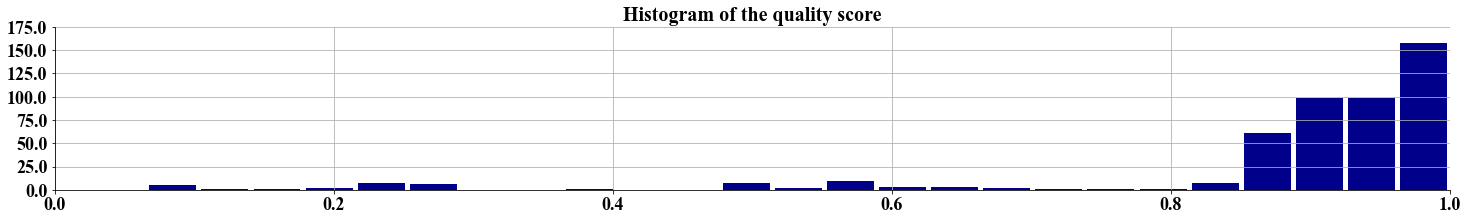

In [136]:
#weighted_confidence_score = np.multiply(conf_values, general_shap_values_normalized).sum(axis=1)
fi(25, 3)
plt.title("Histogram of the quality score", weight='bold', fontsize=20, **csfont)
plt.hist(weighted_confidence_score.flatten(), color='darkblue', bins=25, rwidth=.9)

#plt.xticks(ticks = np.arange(features_importances_extended.shape[0]), labels=[feature_name_mapping[f] for f in np.array(labels)[idx_sorting]], rotation =90)
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.xlim([0, 1])
plt.gca().set_yticks(plt.gca().get_yticks(), np.round(plt.gca().get_yticks(), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.gca().set_xticks(plt.gca().get_xticks(), np.round(plt.gca().get_xticks(), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.grid()
plt.savefig(os.path.join(ROOT_DIR, 'figures', 'compliance_score_hist_ddld.png'), dpi=200, bbox_inches = 'tight', facecolor=plt.gcf().get_facecolor(), edgecolor='none')



None

**Now that we have the weigth we try to see whetehr it improves the performances.**

In [138]:
use_weight = True
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal_ddld.npy'))
else:
    weighted_confidence_score = None
    
    
K = 100

random_states = np.random.randint(0, 1000, K)

for i, random_state in enumerate(random_states):

    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='imputation',
                   imputation_method='constant',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular_ddld', 
                   positive_class = [1],
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=False,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='54_Janvier_Final_Importance_Computation_ddld_with_weight', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = i, 
                      verbosity=1, 
                      save_experiment=True)

    exp.fit_predict(num_cv=5, sample_weight=weighted_confidence_score, random_state=random_state)
    display(exp.performances_df)
    
    

Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 1!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,0,0.834,0.379,0.853,0.129,0.892,0.593,0.119,0.593,0.248,0.714,0.372,0.898,0.692,0.251,0.064,0.983,0.102,0.749,0.017,44,295,131,5


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 2!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,1,0.806,0.367,0.827,0.116,0.923,0.557,0.172,0.557,0.308,0.84,0.398,0.653,0.862,0.352,0.099,0.956,0.347,0.648,0.044,32,367,59,17


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 3!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,2,0.805,0.394,0.849,0.199,0.97,0.565,0.115,0.565,0.238,0.718,0.345,0.837,0.704,0.246,0.062,0.974,0.163,0.754,0.026,41,300,126,8


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 4!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,3,0.816,0.384,0.873,0.135,0.873,0.599,0.16,0.599,0.304,0.815,0.412,0.755,0.822,0.327,0.09,0.967,0.245,0.673,0.033,37,350,76,12


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 5!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,4,0.843,0.457,0.891,0.211,0.976,0.61,0.147,0.61,0.289,0.787,0.408,0.816,0.784,0.303,0.081,0.974,0.184,0.697,0.026,40,334,92,9


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 6!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,5,0.834,0.415,0.865,0.161,0.948,0.608,0.14,0.608,0.28,0.773,0.401,0.837,0.765,0.291,0.077,0.976,0.163,0.709,0.024,41,326,100,8


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 7!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,6,0.835,0.407,0.89,0.139,0.936,0.596,0.132,0.596,0.268,0.709,0.368,0.898,0.688,0.249,0.063,0.983,0.102,0.751,0.017,44,293,133,5


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 8!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,7,0.823,0.36,0.849,0.123,0.896,0.591,0.121,0.591,0.251,0.724,0.372,0.878,0.707,0.256,0.065,0.98,0.122,0.744,0.02,43,301,125,6


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 9!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,8,0.825,0.425,0.878,0.163,0.943,0.569,0.187,0.569,0.326,0.758,0.353,0.776,0.756,0.268,0.069,0.967,0.224,0.732,0.033,38,322,104,11


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 10!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,9,0.822,0.374,0.783,0.163,0.947,0.606,0.15,0.606,0.293,0.796,0.408,0.796,0.796,0.31,0.083,0.971,0.204,0.69,0.029,39,339,87,10


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 11!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,10,0.83,0.424,0.861,0.189,0.967,0.557,0.115,0.557,0.237,0.722,0.338,0.816,0.711,0.245,0.062,0.971,0.184,0.755,0.029,40,303,123,9


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 12!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,11,0.819,0.396,0.884,0.132,0.926,0.544,0.102,0.544,0.216,0.674,0.316,0.857,0.653,0.221,0.054,0.975,0.143,0.779,0.025,42,278,148,7


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 13!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,12,0.781,0.397,0.888,0.158,0.941,0.516,0.124,0.516,0.243,0.775,0.318,0.673,0.786,0.266,0.068,0.954,0.327,0.734,0.046,33,335,91,16


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 14!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,13,0.845,0.432,0.88,0.161,0.942,0.621,0.138,0.621,0.28,0.762,0.41,0.878,0.749,0.287,0.075,0.982,0.122,0.713,0.018,43,319,107,6


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 15!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,14,0.84,0.431,0.879,0.169,0.943,0.611,0.155,0.611,0.3,0.802,0.416,0.796,0.803,0.317,0.086,0.972,0.204,0.683,0.028,39,342,84,10


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 16!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,15,0.85,0.453,0.905,0.171,0.949,0.599,0.153,0.599,0.295,0.802,0.405,0.776,0.805,0.314,0.085,0.969,0.224,0.686,0.031,38,343,83,11


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 17!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,16,0.84,0.435,0.861,0.173,0.955,0.61,0.182,0.61,0.331,0.84,0.439,0.735,0.852,0.364,0.104,0.965,0.265,0.636,0.035,36,363,63,13


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 18!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,17,0.837,0.451,0.899,0.207,0.975,0.583,0.129,0.583,0.261,0.756,0.372,0.816,0.749,0.272,0.07,0.973,0.184,0.728,0.027,40,319,107,9


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 19!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,18,0.845,0.411,0.886,0.134,0.867,0.599,0.194,0.599,0.342,0.756,0.382,0.837,0.746,0.275,0.071,0.975,0.163,0.725,0.025,41,318,108,8


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 20!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,19,0.833,0.443,0.906,0.181,0.949,0.597,0.159,0.597,0.301,0.813,0.409,0.755,0.819,0.325,0.089,0.967,0.245,0.675,0.033,37,349,77,12


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 21!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,20,0.825,0.417,0.865,0.203,0.973,0.599,0.139,0.599,0.278,0.775,0.393,0.816,0.77,0.29,0.076,0.973,0.184,0.71,0.027,40,328,98,9


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 22!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,21,0.831,0.423,0.889,0.19,0.973,0.587,0.123,0.587,0.253,0.686,0.359,0.918,0.66,0.237,0.059,0.986,0.082,0.763,0.014,45,281,145,4


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 23!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,22,0.84,0.405,0.882,0.137,0.939,0.576,0.111,0.576,0.233,0.691,0.352,0.898,0.667,0.237,0.059,0.983,0.102,0.763,0.017,44,284,142,5


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 24!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,23,0.828,0.384,0.847,0.126,0.935,0.607,0.167,0.607,0.314,0.823,0.424,0.755,0.831,0.339,0.094,0.967,0.245,0.661,0.033,37,354,72,12


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 25!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,24,0.818,0.384,0.839,0.159,0.958,0.575,0.129,0.575,0.26,0.76,0.366,0.796,0.756,0.273,0.07,0.97,0.204,0.727,0.03,39,322,104,10


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 26!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,25,0.826,0.435,0.898,0.169,0.915,0.578,0.126,0.578,0.256,0.749,0.365,0.816,0.742,0.267,0.068,0.972,0.184,0.733,0.028,40,316,110,9


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 27!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,26,0.806,0.379,0.843,0.128,0.936,0.544,0.12,0.544,0.243,0.749,0.333,0.755,0.749,0.257,0.065,0.964,0.245,0.743,0.036,37,319,107,12


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 28!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,27,0.835,0.394,0.885,0.129,0.911,0.579,0.161,0.579,0.301,0.821,0.4,0.714,0.833,0.33,0.091,0.962,0.286,0.67,0.038,35,355,71,14


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 29!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,28,0.821,0.414,0.89,0.146,0.944,0.587,0.195,0.587,0.339,0.857,0.438,0.673,0.878,0.388,0.114,0.959,0.327,0.612,0.041,33,374,52,16


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 30!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,29,0.803,0.361,0.846,0.123,0.895,0.567,0.13,0.567,0.259,0.764,0.36,0.776,0.763,0.273,0.071,0.967,0.224,0.727,0.033,38,325,101,11


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 31!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,30,0.817,0.404,0.847,0.178,0.963,0.579,0.151,0.579,0.289,0.806,0.39,0.735,0.815,0.313,0.084,0.964,0.265,0.687,0.036,36,347,79,13


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 32!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,31,0.826,0.468,0.919,0.263,0.984,0.579,0.132,0.579,0.264,0.764,0.37,0.796,0.761,0.277,0.072,0.97,0.204,0.723,0.03,39,324,102,10


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 33!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,32,0.817,0.388,0.865,0.153,0.949,0.575,0.113,0.575,0.237,0.703,0.352,0.878,0.683,0.242,0.061,0.98,0.122,0.758,0.02,43,291,135,6


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 34!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,33,0.819,0.396,0.884,0.132,0.926,0.544,0.102,0.544,0.216,0.674,0.316,0.857,0.653,0.221,0.054,0.975,0.143,0.779,0.025,42,278,148,7


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 35!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,34,0.84,0.419,0.859,0.188,0.97,0.577,0.131,0.577,0.262,0.762,0.368,0.796,0.758,0.275,0.071,0.97,0.204,0.725,0.03,39,323,103,10


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 36!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,35,0.837,0.411,0.838,0.17,0.958,0.573,0.112,0.573,0.236,0.701,0.35,0.878,0.681,0.24,0.06,0.98,0.122,0.76,0.02,43,290,136,6


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 37!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,36,0.839,0.401,0.857,0.142,0.93,0.623,0.165,0.623,0.314,0.815,0.433,0.796,0.817,0.333,0.092,0.972,0.204,0.667,0.028,39,348,78,10


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 38!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,37,0.845,0.412,0.863,0.144,0.896,0.619,0.191,0.619,0.344,0.848,0.453,0.735,0.862,0.379,0.11,0.966,0.265,0.621,0.034,36,367,59,13


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 39!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,38,0.835,0.389,0.865,0.126,0.927,0.586,0.143,0.586,0.28,0.787,0.387,0.776,0.789,0.297,0.079,0.968,0.224,0.703,0.032,38,336,90,11


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 40!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,39,0.84,0.439,0.895,0.169,0.945,0.611,0.171,0.611,0.319,0.827,0.43,0.755,0.836,0.346,0.097,0.967,0.245,0.654,0.033,37,356,70,12


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 41!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,40,0.845,0.439,0.87,0.185,0.966,0.596,0.167,0.596,0.311,0.825,0.417,0.735,0.836,0.34,0.094,0.965,0.265,0.66,0.035,36,356,70,13


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 42!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,41,0.835,0.39,0.834,0.138,0.927,0.604,0.128,0.604,0.263,0.741,0.388,0.878,0.725,0.269,0.069,0.981,0.122,0.731,0.019,43,309,117,6


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 43!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,42,0.819,0.385,0.862,0.14,0.934,0.58,0.119,0.58,0.247,0.724,0.361,0.857,0.709,0.253,0.064,0.977,0.143,0.747,0.023,42,302,124,7


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 44!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,43,0.836,0.469,0.922,0.204,0.952,0.603,0.124,0.603,0.256,0.726,0.384,0.898,0.707,0.26,0.066,0.984,0.102,0.74,0.016,44,301,125,5


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 45!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,44,0.791,0.327,0.797,0.122,0.92,0.541,0.103,0.541,0.218,0.684,0.315,0.837,0.667,0.224,0.055,0.973,0.163,0.776,0.027,41,284,142,8


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 46!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,45,0.828,0.41,0.864,0.17,0.947,0.578,0.143,0.578,0.279,0.792,0.381,0.755,0.796,0.298,0.079,0.966,0.245,0.702,0.034,37,339,87,12


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 47!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,46,0.836,0.431,0.883,0.193,0.972,0.607,0.152,0.607,0.295,0.798,0.41,0.796,0.798,0.312,0.084,0.971,0.204,0.688,0.029,39,340,86,10


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 48!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,47,0.831,0.377,0.842,0.125,0.936,0.59,0.146,0.59,0.284,0.792,0.392,0.776,0.793,0.302,0.08,0.968,0.224,0.698,0.032,38,338,88,11


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 49!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,48,0.826,0.396,0.862,0.152,0.941,0.566,0.141,0.566,0.274,0.703,0.342,0.857,0.685,0.239,0.06,0.977,0.143,0.761,0.023,42,292,134,7


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 50!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,49,0.807,0.352,0.855,0.11,0.902,0.592,0.125,0.592,0.257,0.739,0.375,0.857,0.725,0.264,0.068,0.978,0.143,0.736,0.022,42,309,117,7


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 51!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,50,0.821,0.343,0.79,0.1,0.856,0.576,0.121,0.576,0.248,0.733,0.359,0.837,0.721,0.256,0.065,0.975,0.163,0.744,0.025,41,307,119,8


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 52!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,51,0.827,0.397,0.871,0.15,0.94,0.596,0.12,0.596,0.251,0.718,0.376,0.898,0.697,0.254,0.065,0.983,0.102,0.746,0.017,44,297,129,5


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 53!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,52,0.809,0.344,0.845,0.107,0.905,0.565,0.111,0.565,0.233,0.703,0.342,0.857,0.685,0.239,0.06,0.977,0.143,0.761,0.023,42,292,134,7


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 54!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,53,0.835,0.389,0.865,0.126,0.927,0.586,0.143,0.586,0.28,0.787,0.387,0.776,0.789,0.297,0.079,0.968,0.224,0.703,0.032,38,336,90,11


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 55!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,54,0.818,0.369,0.857,0.116,0.922,0.562,0.138,0.562,0.27,0.714,0.341,0.837,0.7,0.243,0.061,0.974,0.163,0.757,0.026,41,298,128,8


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 56!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,55,0.847,0.431,0.899,0.158,0.948,0.597,0.125,0.597,0.257,0.733,0.38,0.878,0.716,0.262,0.067,0.981,0.122,0.738,0.019,43,305,121,6


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 57!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,56,0.83,0.436,0.883,0.163,0.93,0.579,0.138,0.579,0.272,0.731,0.357,0.837,0.718,0.255,0.065,0.975,0.163,0.745,0.025,41,306,120,8


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 58!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,57,0.823,0.421,0.899,0.161,0.916,0.575,0.129,0.575,0.26,0.76,0.366,0.796,0.756,0.273,0.07,0.97,0.204,0.727,0.03,39,322,104,10


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 59!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,58,0.842,0.386,0.861,0.121,0.912,0.586,0.179,0.586,0.323,0.749,0.365,0.816,0.742,0.267,0.068,0.972,0.184,0.733,0.028,40,316,110,9


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 60!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,59,0.847,0.467,0.893,0.214,0.972,0.597,0.179,0.597,0.325,0.766,0.383,0.816,0.761,0.282,0.073,0.973,0.184,0.718,0.027,40,324,102,9


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 61!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,60,0.824,0.412,0.898,0.151,0.946,0.559,0.109,0.559,0.228,0.695,0.334,0.857,0.676,0.233,0.058,0.976,0.143,0.767,0.024,42,288,138,7


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 62!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,61,0.816,0.397,0.829,0.188,0.965,0.606,0.15,0.606,0.293,0.796,0.408,0.796,0.796,0.31,0.083,0.971,0.204,0.69,0.029,39,339,87,10


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 63!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,62,0.823,0.421,0.899,0.161,0.916,0.575,0.129,0.575,0.26,0.76,0.366,0.796,0.756,0.273,0.07,0.97,0.204,0.727,0.03,39,322,104,10


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 64!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,63,0.832,0.435,0.909,0.165,0.948,0.582,0.175,0.582,0.317,0.714,0.351,0.857,0.697,0.246,0.062,0.977,0.143,0.754,0.023,42,297,129,7


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 65!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,64,0.825,0.417,0.865,0.203,0.973,0.599,0.139,0.599,0.278,0.775,0.393,0.816,0.77,0.29,0.076,0.973,0.184,0.71,0.027,40,328,98,9


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 66!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,65,0.822,0.407,0.87,0.169,0.96,0.574,0.11,0.574,0.232,0.688,0.35,0.898,0.664,0.235,0.059,0.983,0.102,0.765,0.017,44,283,143,5


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 67!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,66,0.798,0.41,0.896,0.178,0.947,0.542,0.11,0.542,0.229,0.716,0.321,0.796,0.707,0.238,0.059,0.968,0.204,0.762,0.032,39,301,125,10


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 68!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,67,0.844,0.426,0.888,0.15,0.942,0.577,0.181,0.577,0.323,0.716,0.353,0.857,0.7,0.247,0.062,0.977,0.143,0.753,0.023,42,298,128,7


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 69!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,68,0.815,0.352,0.841,0.106,0.872,0.565,0.147,0.565,0.281,0.667,0.333,0.898,0.641,0.223,0.055,0.982,0.102,0.777,0.018,44,273,153,5


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 70!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,69,0.826,0.365,0.812,0.147,0.945,0.625,0.141,0.625,0.284,0.766,0.414,0.878,0.754,0.291,0.076,0.982,0.122,0.709,0.018,43,321,105,6


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 71!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,70,0.832,0.429,0.887,0.185,0.971,0.585,0.142,0.585,0.278,0.771,0.378,0.796,0.768,0.283,0.074,0.97,0.204,0.717,0.03,39,327,99,10


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 72!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,71,0.814,0.366,0.842,0.124,0.885,0.565,0.147,0.565,0.281,0.804,0.377,0.714,0.815,0.307,0.082,0.961,0.286,0.693,0.039,35,347,79,14


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 73!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,72,0.815,0.347,0.854,0.104,0.809,0.544,0.169,0.544,0.302,0.634,0.307,0.898,0.603,0.207,0.05,0.981,0.102,0.793,0.019,44,257,169,5


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 74!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,73,0.822,0.363,0.804,0.127,0.919,0.584,0.156,0.584,0.296,0.813,0.399,0.735,0.822,0.321,0.087,0.964,0.265,0.679,0.036,36,350,76,13


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 75!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,74,0.813,0.425,0.891,0.202,0.975,0.55,0.152,0.55,0.284,0.785,0.353,0.714,0.793,0.285,0.074,0.96,0.286,0.715,0.04,35,338,88,14


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 76!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,75,0.846,0.454,0.897,0.189,0.965,0.598,0.145,0.598,0.285,0.787,0.397,0.796,0.786,0.3,0.08,0.971,0.204,0.7,0.029,39,335,91,10


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 77!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,76,0.836,0.422,0.889,0.149,0.944,0.583,0.129,0.583,0.261,0.756,0.372,0.816,0.749,0.272,0.07,0.973,0.184,0.728,0.027,40,319,107,9


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 78!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,77,0.821,0.462,0.911,0.228,0.98,0.569,0.172,0.569,0.311,0.838,0.405,0.673,0.857,0.351,0.099,0.958,0.327,0.649,0.042,33,365,61,16


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 79!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,78,0.823,0.388,0.867,0.127,0.933,0.579,0.151,0.579,0.289,0.806,0.39,0.735,0.815,0.313,0.084,0.964,0.265,0.687,0.036,36,347,79,13


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 80!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,79,0.845,0.444,0.902,0.176,0.948,0.598,0.133,0.598,0.269,0.76,0.387,0.837,0.751,0.279,0.073,0.976,0.163,0.721,0.024,41,320,106,8


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 81!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,80,0.831,0.405,0.861,0.149,0.935,0.594,0.148,0.594,0.288,0.796,0.397,0.776,0.798,0.306,0.082,0.969,0.224,0.694,0.031,38,340,86,11


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 82!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,81,0.806,0.384,0.871,0.152,0.942,0.552,0.112,0.552,0.233,0.716,0.332,0.816,0.704,0.241,0.06,0.971,0.184,0.759,0.029,40,300,126,9


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 83!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,82,0.811,0.343,0.817,0.113,0.821,0.582,0.124,0.582,0.254,0.741,0.367,0.837,0.73,0.263,0.067,0.975,0.163,0.737,0.025,41,311,115,8


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 84!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,83,0.834,0.408,0.875,0.136,0.911,0.579,0.118,0.579,0.245,0.722,0.359,0.857,0.707,0.251,0.064,0.977,0.143,0.749,0.023,42,301,125,7


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 85!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,84,0.828,0.429,0.88,0.207,0.976,0.579,0.132,0.579,0.264,0.764,0.37,0.796,0.761,0.277,0.072,0.97,0.204,0.723,0.03,39,324,102,10


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 86!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,85,0.833,0.4,0.878,0.148,0.939,0.612,0.138,0.612,0.277,0.764,0.402,0.857,0.754,0.286,0.075,0.979,0.143,0.714,0.021,42,321,105,7


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 87!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,86,0.831,0.401,0.853,0.141,0.875,0.58,0.145,0.58,0.281,0.794,0.384,0.755,0.798,0.301,0.08,0.966,0.245,0.699,0.034,37,340,86,12


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 88!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,87,0.818,0.408,0.865,0.184,0.97,0.602,0.142,0.602,0.281,0.779,0.398,0.816,0.775,0.294,0.078,0.973,0.184,0.706,0.027,40,330,96,9


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 89!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,88,0.833,0.407,0.885,0.149,0.929,0.574,0.134,0.574,0.266,0.773,0.369,0.776,0.772,0.281,0.073,0.968,0.224,0.719,0.032,38,329,97,11


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 90!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,89,0.832,0.406,0.855,0.156,0.943,0.619,0.154,0.619,0.3,0.798,0.421,0.816,0.796,0.315,0.085,0.974,0.184,0.685,0.026,40,339,87,9


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 91!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,90,0.826,0.4,0.889,0.151,0.946,0.585,0.149,0.585,0.287,0.8,0.392,0.755,0.805,0.308,0.083,0.966,0.245,0.692,0.034,37,343,83,12


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 92!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,91,0.831,0.425,0.897,0.171,0.947,0.57,0.152,0.57,0.288,0.811,0.385,0.714,0.822,0.315,0.085,0.962,0.286,0.685,0.038,35,350,76,14


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 93!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,92,0.822,0.38,0.864,0.126,0.936,0.581,0.139,0.581,0.274,0.781,0.379,0.776,0.782,0.29,0.076,0.968,0.224,0.71,0.032,38,333,93,11


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 94!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,93,0.811,0.366,0.864,0.115,0.895,0.559,0.116,0.559,0.238,0.724,0.34,0.816,0.714,0.247,0.062,0.971,0.184,0.753,0.029,40,304,122,9


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 95!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,94,0.805,0.405,0.869,0.183,0.969,0.562,0.122,0.562,0.247,0.743,0.348,0.796,0.737,0.258,0.066,0.969,0.204,0.742,0.031,39,314,112,10


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 96!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,95,0.823,0.379,0.854,0.13,0.896,0.571,0.132,0.571,0.263,0.768,0.365,0.776,0.768,0.277,0.072,0.967,0.224,0.723,0.033,38,327,99,11


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 97!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,96,0.844,0.447,0.882,0.193,0.971,0.61,0.137,0.61,0.275,0.747,0.394,0.878,0.732,0.274,0.071,0.981,0.122,0.726,0.019,43,312,114,6


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 98!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,97,0.831,0.401,0.878,0.146,0.897,0.584,0.114,0.584,0.24,0.701,0.361,0.898,0.678,0.243,0.061,0.983,0.102,0.757,0.017,44,289,137,5


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 99!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,98,0.805,0.383,0.853,0.154,0.955,0.556,0.122,0.556,0.247,0.749,0.344,0.776,0.746,0.26,0.066,0.967,0.224,0.74,0.033,38,318,108,11


Saving experiment in folder 54_Janvier_Final_Importance_Computation_ddld_with_weight.
Doing experiment 100!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,99,0.835,0.42,0.895,0.158,0.915,0.623,0.145,0.623,0.289,0.777,0.416,0.857,0.768,0.298,0.079,0.979,0.143,0.702,0.021,42,327,99,7


In [95]:
# PERFORMANCES WITHOUT WEIGHTING 


#df = create_autism_df(folder_names = ['24_Janvier_Final_Importance_Computation_with_pwb_ddld_depth_5_test_1'])#'13_november_bis'])#'November 2022'])
df = create_autism_df(folder_names = ['54_Janvier_Final_Importance_Computation_ddld_without_weight'])#'13_november_bis'])#'November 2022'])



# With BLink without weight with pwb DDLD depth 3 200 est loocv
display(df[['AUROC', 'Sensitivity', 'Specificity']].mean())


conslusiveness_score = []
for i, row in df.iterrows():

    y_true = row['y_true'][0]
    y_pred = row['y_pred'][0]
    conslusiveness_score.append(list((y_pred >row['optimal_threshold']).astype(int)))
conslusiveness_score = np.array(conslusiveness_score).mean(axis=0)

max_youden, index_threshold, optimal_threshold = find_optimal_threshold_youden(y_true, conslusiveness_score)
display(compute_results(y_true, conslusiveness_score, optimal_threshold)[['AUROC', 'Sensitivity, recall, hit rate, or true positive rate (TPR)', 'Specificity, selectivity or true negative rate (TNR)']])

100%|██████████| 101/101 [00:33<00:00,  3.02it/s]


AUROC          0.82540
Sensitivity    0.78515
Specificity    0.76289
dtype: float64

,AUROC,"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)"
?\n(N=475),0.864,0.816,0.8


In [ ]:
# PERFORMANCES WITHOUT WEIGHTING 


#df = create_autism_df(folder_names = ['24_Janvier_Final_Importance_Computation_with_pwb_ddld_depth_5_test_1'])#'13_november_bis'])#'November 2022'])
df = create_autism_df(folder_names = ['54_Janvier_Final_Importance_Computation_ddld_without_weight'])#'13_november_bis'])#'November 2022'])



# With BLink without weight with pwb DDLD depth 3 200 est loocv
display(df[['AUROC', 'Sensitivity', 'Specificity']].mean())


conslusiveness_score = []
for i, row in df.iterrows():

    y_true = row['y_true'][0]
    y_pred = row['y_pred'][0]
    conslusiveness_score.append(list((y_pred >row['optimal_threshold']).astype(int)))
conslusiveness_score = np.array(conslusiveness_score).mean(axis=0)

max_youden, index_threshold, optimal_threshold = find_optimal_threshold_youden(y_true, conslusiveness_score)
display(compute_results(y_true, conslusiveness_score, optimal_threshold)#[['AUROC', 'Sensitivity, recall, hit rate, or true positive rate (TPR)', 'Specificity, selectivity or true negative rate (TNR)']])

In [139]:
# PERFORMANCES WITH WEIGHTING 


#df = create_autism_df(folder_names = ['24_Janvier_Final_Importance_Computation_with_pwb_ddld_depth_5_test_1'])#'13_november_bis'])#'November 2022'])
df = create_autism_df(folder_names = ['54_Janvier_Final_Importance_Computation_ddld_with_weight'])#'13_november_bis'])#'November 2022'])



# With BLink without weight with pwb DDLD depth 3 200 est loocv
display(df[['AUROC', 'Sensitivity', 'Specificity']].mean())


conslusiveness_score = []
for i, row in df.iterrows():

    y_true = row['y_true'][0]
    y_pred = row['y_pred'][0]
    conslusiveness_score.append(list((y_pred >row['optimal_threshold']).astype(int)))
conslusiveness_score = np.array(conslusiveness_score).mean(axis=0)

max_youden, index_threshold, optimal_threshold = find_optimal_threshold_youden(y_true, conslusiveness_score )
display(compute_results(y_true, conslusiveness_score, optimal_threshold)[['AUROC', 'Sensitivity, recall, hit rate, or true positive rate (TPR)', 'Specificity, selectivity or true negative rate (TNR)']])

100%|██████████| 101/101 [00:32<00:00,  3.08it/s]


AUROC          0.82646
Sensitivity    0.80903
Specificity    0.75346
dtype: float64

,AUROC,"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)"
?\n(N=475),0.857,0.776,0.829


# Conclusion

> For the comparison between autistic and non-autistic, we will not weight samples based on theirquality score during trrianing. 